# Titanic - Machine Learning from Disaster

Name: Guy Simai

Kaggle: https://www.kaggle.com/guysimai

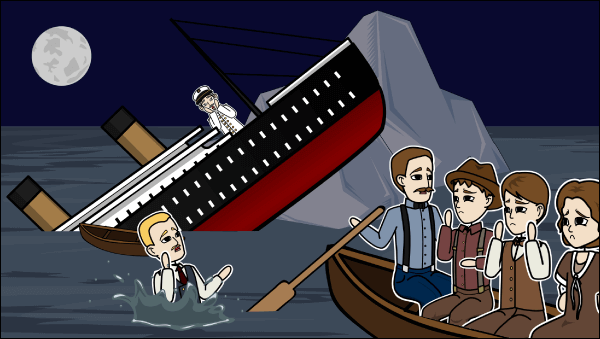

# About the competition

The sinking of the Titanic is one of the most infamous shipwrecks in history.
On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.
While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this project I process the data of the the survivors and create a hypothesis that will predict who survived and who did not by the given features.

# Imports and Definitions

In [85]:
# import numpy, matplotlib, etc.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import neural_network
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20

# Preprocessing on train and test data  

## lets look at our data frame.

In [86]:
#read train cvs file with pandas
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
train.keys()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

**Feature Description**:
We have 12 columns; 11 features and 1 lable.

**The Features:**  
* PassengerId: Identification number.  
* Pclass: Ticket Class (1 - Upper, 2 - Middle, 3 - Lower)  
* Name: passenger Name  
* Sex: gender  
* Age: Passenger age  
* SibSp: Count of siblings / spouses aboard the Titanic  
* Parch: Count of parents / children aboard the Titanic  
* Ticket: Ticket number  
* Fare: Passenger fare of ticket  
* Cabin: Passenger cabin number  
* Embarked: Port of Embarkation (String: C = Cherbourg, Q = Queenstown, S = Southampton)  

**The Target:**  
* Survived: Did the passenger survive (0-Dead, 1- Survived)

In [87]:
display(train)

PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ...    ...   
886                              Montvila, Rev. Juozas    male  27.0      0   
887                       Graham, Miss. Margaret Edith  female  19.0      0   
888           Johnston, Miss. Catherine Helen "Carrie"  female   NaN      1   
889                              Behr, Mr. Karl Howell    male  26.0      0   
890                                Dooley, Mr. Patrick    male  32.0      0   

     Parch            Ticket     Fare Cabin Embarked  
0        0         A/5 21171   7.2500   NaN        S  
1        0          PC 17599  71.2833   C85        C  
2        0  STON/O2. 3101282   7.9250   NaN        S  
3        0            113803  53.1000  C123        S  
4        0            373450   8.0500   NaN        S  
..     ...               ...      ...   ...      ...  
886      0            211536  13.0000   NaN        S  
887      0            112053  30.0000   B42        S  
888      2        W./C. 6607  23.4500   NaN        S  
889      0            111369  30.0000  C148        C  
890      0            370376   7.7500   NaN        Q  

[891 rows x 12 columns]

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* there is some missing data.
* PassengerId and Name columns are not going to help us predict Survived column.

## Present the missing data and try to predict the missing values.

In [89]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Filling Age**  
I fill in the age according to each person's title in their names.  
For exemple: "Mr.", "Miss.".

In [90]:
# Create a new column for passengers' title.
train['Title'] = train.Name.str.extract('([A-Za-z]+)\.')
test['Title'] = test.Name.str.extract('([A-Za-z]+)\.')

# Get mean age by title.
meanAges = train.groupby('Title')['Age'].mean()

print('Mean ages by passengers title:\n', meanAges)

titles = train.Title.unique()

# Fill missing ages.
for title, age in zip(titles, meanAges):
    train.loc[(train.Age.isnull()) & (train.Title == title), 'Age'] = age
    test.loc[(test.Age.isnull()) & (test.Title == title), 'Age'] = age

Mean ages by passengers title:
 Title
Capt        70.000000
Col         58.000000
Countess    33.000000
Don         40.000000
Dr          42.000000
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       4.574167
Miss        21.773973
Mlle        24.000000
Mme         24.000000
Mr          32.368090
Mrs         35.898148
Ms          28.000000
Rev         43.166667
Sir         49.000000
Name: Age, dtype: float64


* Lets reduce all those above to 5 titles ('Mr', 'Miss', 'Mrs', 'Master', 'Other').
* Also I noticed that titles 'Ms', 'Mlle' and 'Mme' are english and french abbreviation for 'Miss',
* So lets merge them with 'Miss'.

In [91]:
titles = train.Title.unique()
print("Different titles:\n", titles)
titles_count = pd.Series(train['Title']).value_counts()
print("Title histogram:\n", titles_count)

Different titles:
 ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
Title histogram:
 Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64


In [92]:
others = ['Dr', 'Rev', 'Col', 'Major', 'Capt', 'Jonkheer', 'Don', 'Sir', 'Lady', 'Countess', 'Dona']
# Copy the 'Title' column to a new column 'New_Title'
train['New_Title'] = train['Title'].replace(['Ms', 'Mlle', 'Mme'], 'Miss').replace(others, 'Other')
test['New_Title'] = test['Title'].replace(['Ms', 'Mlle', 'Mme'], 'Miss').replace(others, 'Other')

# Optionally, you can drop the original 'Title' column
train.drop(columns=['Title'], inplace=True)
test.drop(columns=['Title'], inplace=True)

# Rename the 'New_Title' column to 'Title' if you want to keep the original column name
train.rename(columns={'New_Title': 'Title'}, inplace=True)
test.rename(columns={'New_Title': 'Title'}, inplace=True)

**Filling Embarked**  
There are only two missing embarked station data in the information, I will fill them with random values.

In [93]:
# fill empty values in the dataframe by random value from the column
def fill_na_random_pick_column_distribution(df, column_name):
  df_not_null = df[~df[column_name].isnull()]
  df_null = df[df[column_name].isnull()]
  options = np.random.choice(df_not_null[column_name])
  df[column_name] = df[column_name].apply(lambda x: np.random.choice(df_not_null[column_name]) if pd.isnull(x) else x)

In [94]:
fill_na_random_pick_column_distribution(train, 'Embarked')
fill_na_random_pick_column_distribution(test, 'Embarked')

**Filling cabin**  
There are 687 missing values in the cabin column, a very high percentage of lack of information, but very relevant information.  
I believe that at the time the ship was hit, some cabins were more damaged and some were less, the lower cabins are probably in greater danger than the upper ones.  
I will try to find the correlation between the other feature to the cabin.


In [95]:
print(train.Cabin.str[:1].unique())

[nan 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


There are 7 different types of cabins, we will label each of them with a number.

In [96]:
cabin_numeric_alphabet = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F': 5, 'G': 6, 'T': 7}
train['Cabin'] = train['Cabin'].str[:1].map(cabin_numeric_alphabet).astype(float)
test['Cabin'] = test['Cabin'].str[:1].map(cabin_numeric_alphabet).astype(float)


**Correlation with Pclass, Fare and TotalFamily columns**  
I add a feature called TotalFamily to check the relationship between the family size and the group of cabins.

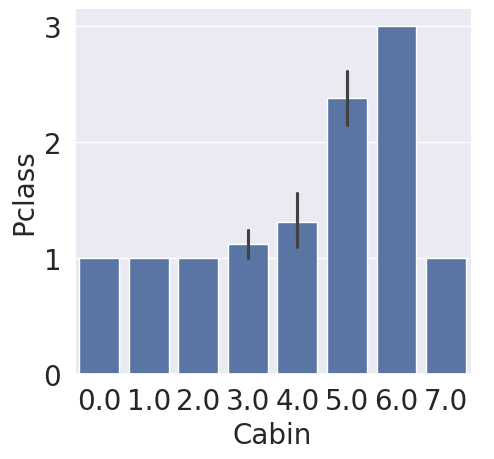

In [97]:
titles = ['Mr', 'Mrs', 'Miss', 'Master', 'Other']
train['Title'] = train['Title'].replace(titles, list(range(len(titles))))
test['Title'] = test['Title'].replace(titles, list(range(len(titles))))

# Plot the catplot
sns.catplot(x='Cabin', y='Pclass', kind='bar', data=train)

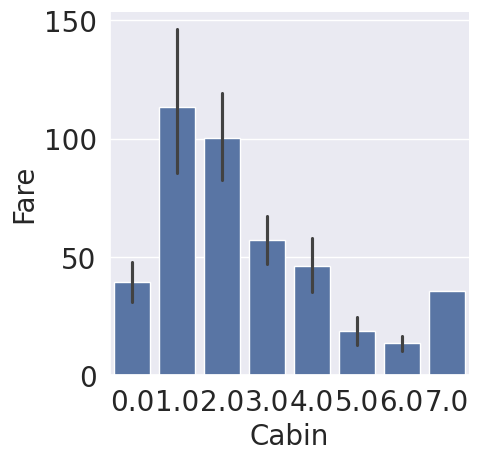

In [98]:
sns.catplot(x='Cabin', y='Fare', kind='bar', data=train)

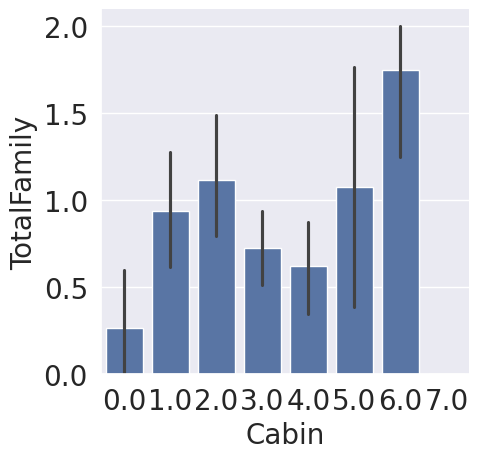

In [99]:
train['TotalFamily'] = train['Parch'] + train['SibSp']
test['TotalFamily'] = train['Parch'] + train['SibSp']
sns.catplot(x='Cabin', y='TotalFamily', kind='bar', data=train)

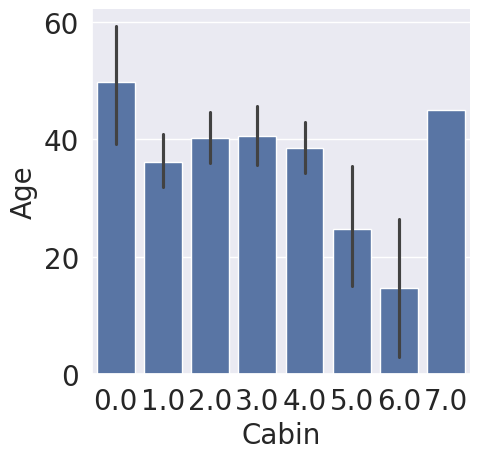

In [100]:
sns.catplot(x='Cabin', y='Age', kind='bar', data=train)

### Inferences:

* Only first class passengers stayed in cabins groups 'A', 'B', 'C', 'T'.
* The heigher the fare was the better cabin.
* cabins group G is a room designed to accommodate probably more people compared to room 1 which has fewer space.
* Mabey cabin A's passengers are some sort of VIPs.
* Maybe there is a connection between age and fare, for example in 'G' the "youngest" paid the least

lets check how many apperances are there.

In [101]:
train.groupby('Cabin')['PassengerId'].nunique()

Cabin
0.0    15
1.0    47
2.0    59
3.0    33
4.0    32
5.0    13
6.0     4
7.0     1
Name: PassengerId, dtype: int64

I observed that there is only one occurrence of the cabin labeled 'T'. To simplify our analysis,  
I have decided to treat it as an outlier and, for the purpose of further investigation, change its designation to cabin 'A',both of tham have similar characteristics.

In [102]:
train['Cabin'] = train['Cabin'].replace({7: 0}).astype(float)
test['Cabin'] = test['Cabin'].replace({7: 0}).astype(float)

* In the plots above we found a good correlation between fare to cabin. Lets find means per cabin and fill missing cabin according to this column.

In [103]:
# get mean fare by cabin.
meanFare = train.groupby('Cabin')['Fare'].mean().round()
# get standart deviation fare by cabin.
stdFare = train.groupby('Cabin')['Fare'].std().round()

print('Mean fare by cabin:\n', meanFare)
print('Std fare by cabin:\n', stdFare)

Mean fare by cabin:
 Cabin
0.0     39.0
1.0    114.0
2.0    100.0
3.0     57.0
4.0     46.0
5.0     19.0
6.0     14.0
Name: Fare, dtype: float64
Std fare by cabin:
 Cabin
0.0     17.0
1.0    109.0
2.0     70.0
3.0     30.0
4.0     33.0
5.0     12.0
6.0      4.0
Name: Fare, dtype: float64


In [104]:
cabins = list(range(7))

def fill_cabin_based_on_fare(row, mean_fare, std_fare):
    fare = row['Fare']

    # Calculate the absolute differences between fare and mean_fare values
    diff = np.abs(mean_fare - fare)

    # Find the index of the minimum difference
    min_diff_index = np.argmin(diff)

    # Return the corresponding Cabin value
    return mean_fare.index[min_diff_index]

# Apply the function to fill missing Cabins based on Fare
train.loc[train['Cabin'].isnull(), 'Cabin'] = train.apply(lambda row: fill_cabin_based_on_fare(row, meanFare, stdFare), axis=1)
test.loc[test['Cabin'].isnull(), 'Cabin'] = test.apply(lambda row: fill_cabin_based_on_fare(row, meanFare, stdFare), axis=1)

# check.
print("Check if there are still NaN Cabins left:\n", train.isnull().sum())

Check if there are still NaN Cabins left:
 PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
TotalFamily    0
dtype: int64


* We filled in all the data of "train",  I will check for missing data in test.

In [105]:
print("Check if there are still NaN Cabins left:\n", test.isnull().sum())

Check if there are still NaN Cabins left:
 PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin          0
Embarked       0
Title          0
TotalFamily    0
dtype: int64


I see that only one Fare data is missing, so I complete it and put the average in it.

In [106]:
def fill_na_median(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    median_value = df_not_null[column_name].median()
    df.loc[df[column_name].isnull(), column_name] = median_value

fill_na_median(test, 'Fare')

In [107]:
test.isna().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin          False
Embarked       False
Title          False
TotalFamily    False
dtype: bool

#### We filled in all the data!

## Remove the irrelevant features
At this point, I remove the irrelevant features, thay aren't going to help us predict Survived column.: Name, Ticket and PassengerId.  

In [108]:
train = train.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

I Change all features to numbers by using LabelEncoder from Sklearn.  
The features: Cabin, Embarked and Sex.

In [109]:
label_encoder = sklearn.preprocessing.LabelEncoder()
train['Cabin'] = label_encoder.fit_transform(train['Cabin'])
train['Embarked'] = label_encoder.fit_transform(train['Embarked']) #0 - C, 1 - Q, 2 - S.
train['Sex'] = label_encoder.fit_transform(train['Sex']) # 0 - female, 1 - male.
train['Title'] = label_encoder.fit_transform(train['Title'])
test['Cabin'] = label_encoder.fit_transform(test['Cabin'])
test['Embarked'] = label_encoder.fit_transform(test['Embarked']) #0 - C, 1 - Q, 2 - S.
test['Sex'] = label_encoder.fit_transform(test['Sex']) # 0 - female, 1 - male.
train['Title'] = label_encoder.fit_transform(train['Title'])


In [110]:
display(train)

Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Cabin  Embarked  \
0           0       3    1  22.0      1      0   7.2500      6         2   
1           1       1    0  38.0      1      0  71.2833      2         0   
2           1       3    0  26.0      0      0   7.9250      6         2   
3           1       1    0  35.0      1      0  53.1000      2         2   
4           0       3    1  35.0      0      0   8.0500      6         2   
..        ...     ...  ...   ...    ...    ...      ...    ...       ...   
886         0       2    1  27.0      0      0  13.0000      6         2   
887         1       1    0  19.0      0      0  30.0000      1         2   
888         0       3    0  33.0      1      2  23.4500      5         2   
889         1       1    1  26.0      0      0  30.0000      2         0   
890         0       3    1  32.0      0      0   7.7500      6         1   

     Title  TotalFamily  
0        0            1  
1        1            1  
2        2            0  
3        1            1  
4        0            0  
..     ...          ...  
886      4            0  
887      2            0  
888      2            3  
889      0            0  
890      0            0  

[891 rows x 11 columns]

# Essential Data Analysis  

## General Information

In [111]:
def create_pie_chart_of_count(df, column, title):
    count_series = df[column].value_counts()
    labels = count_series.index
    sizes = count_series.values

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(title)
    plt.show()

In [112]:
train.describe()

Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.647587   35.821740    0.523008    0.381594   
std      0.486592    0.836071    0.477990   19.112292    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    1.000000   32.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   48.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             Fare       Cabin    Embarked       Title  TotalFamily  
count  891.000000  891.000000  891.000000  891.000000   891.000000  
mean    32.204208    4.519641    1.536476    0.795735     0.904602  
std     49.693429    2.028562    0.791503    1.077254     1.613459  
min      0.000000    0.000000    0.000000    0.000000     0.000000  
25%      7.910400    3.000000    1.000000    0.000000     0.000000  
50%     14.454200    6.000000    2.000000    0.000000     0.000000  
75%     31.000000    6.000000    2.000000    2.000000     1.000000  
max    512.329200    6.000000    2.000000    4.000000    10.000000

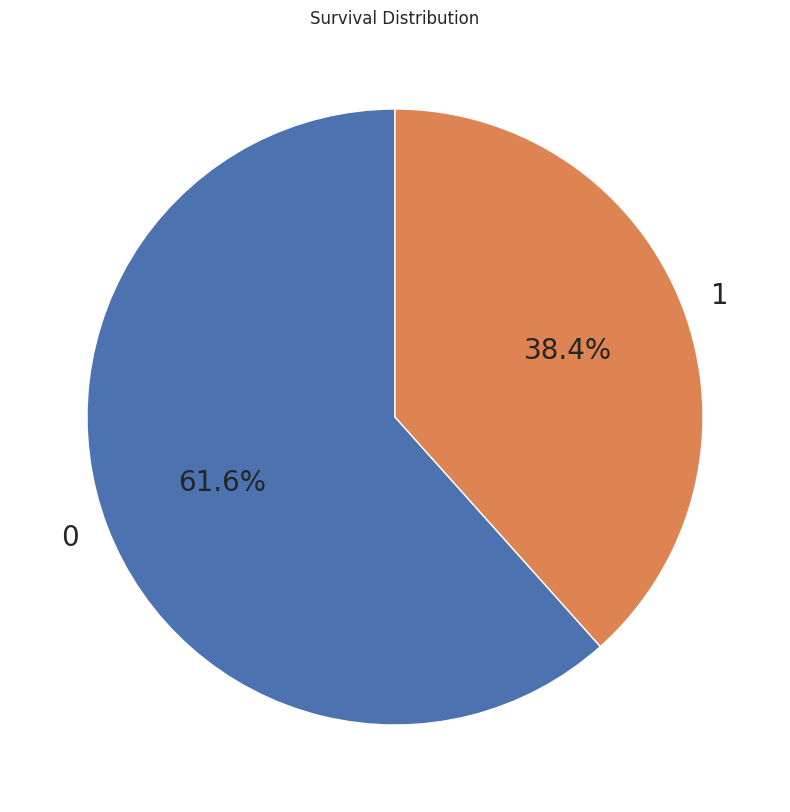

0    549
1    342
Name: Survived, dtype: int64

In [113]:
create_pie_chart_of_count(train, 'Survived', 'Survival Distribution')
train['Survived'].value_counts()

**Pairplot of the features**

<Figure size 1000x1000 with 0 Axes>

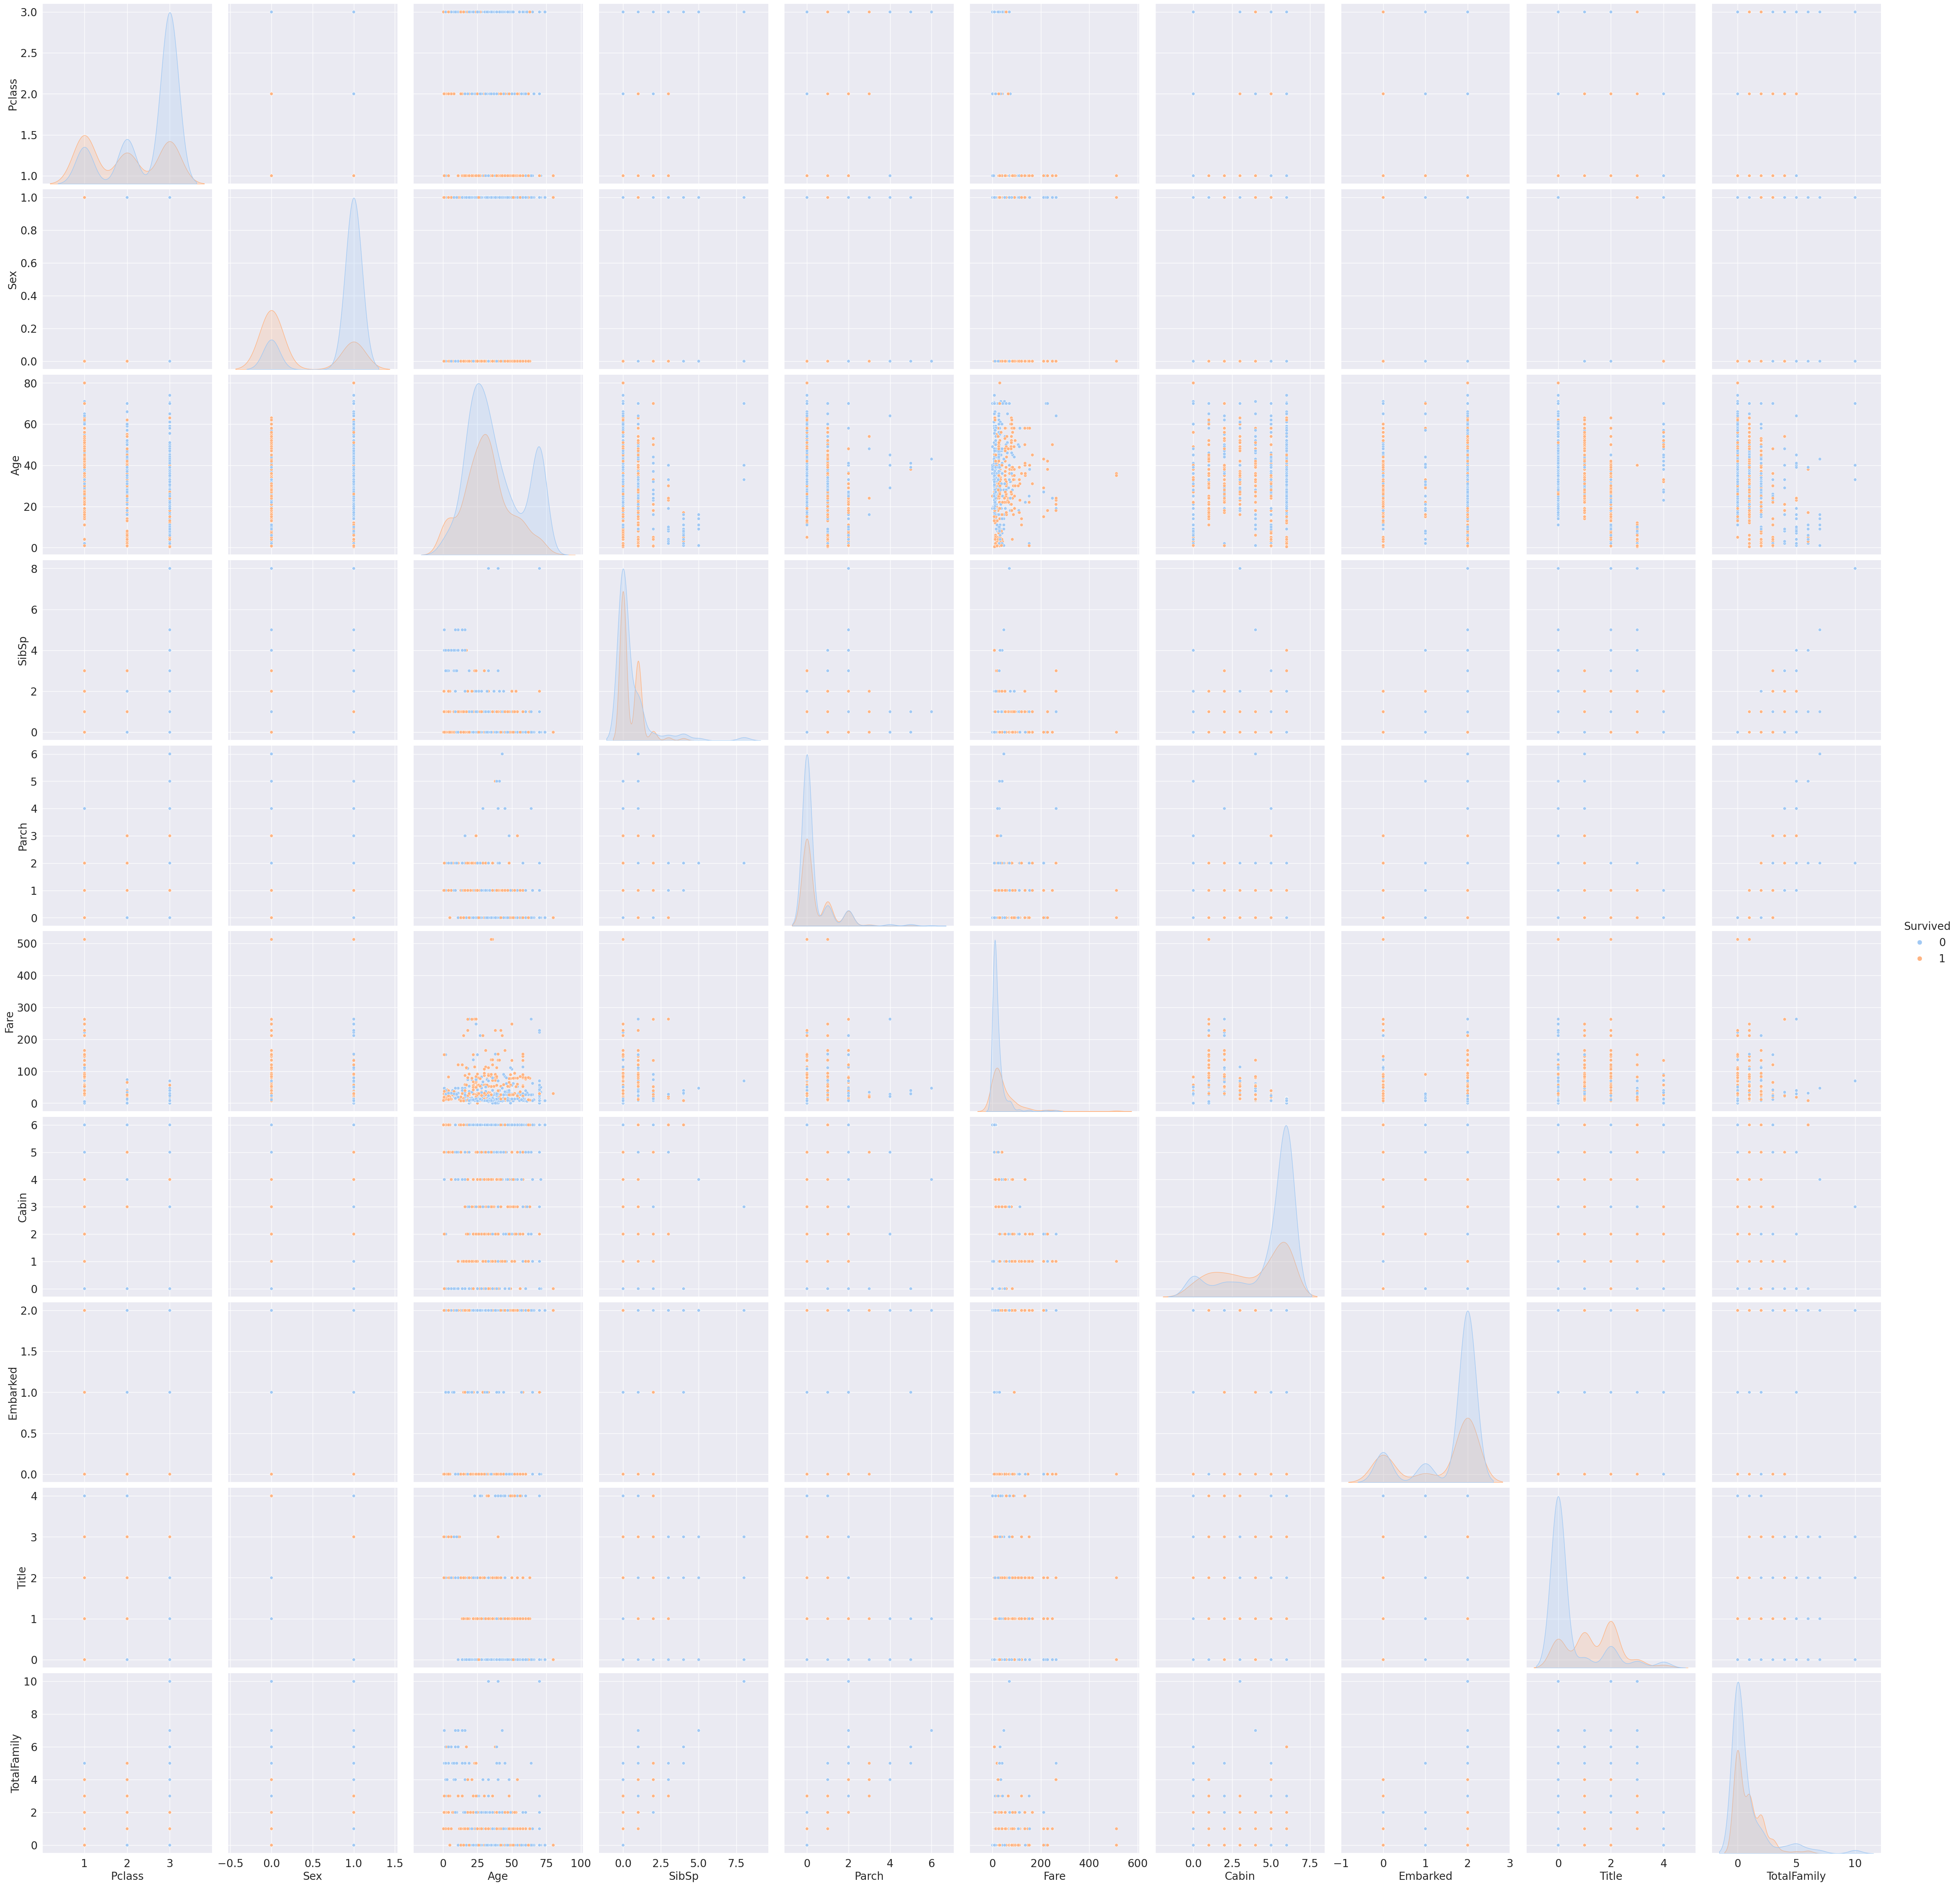

In [114]:
# Show pairplot of the features
import warnings

plt.figure(figsize=(10, 10))
with pd.option_context('mode.use_inf_as_na', True), warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    sns.pairplot(data=train, hue="Survived", palette='pastel', height=5)



* It's hard to see if there are features that related.

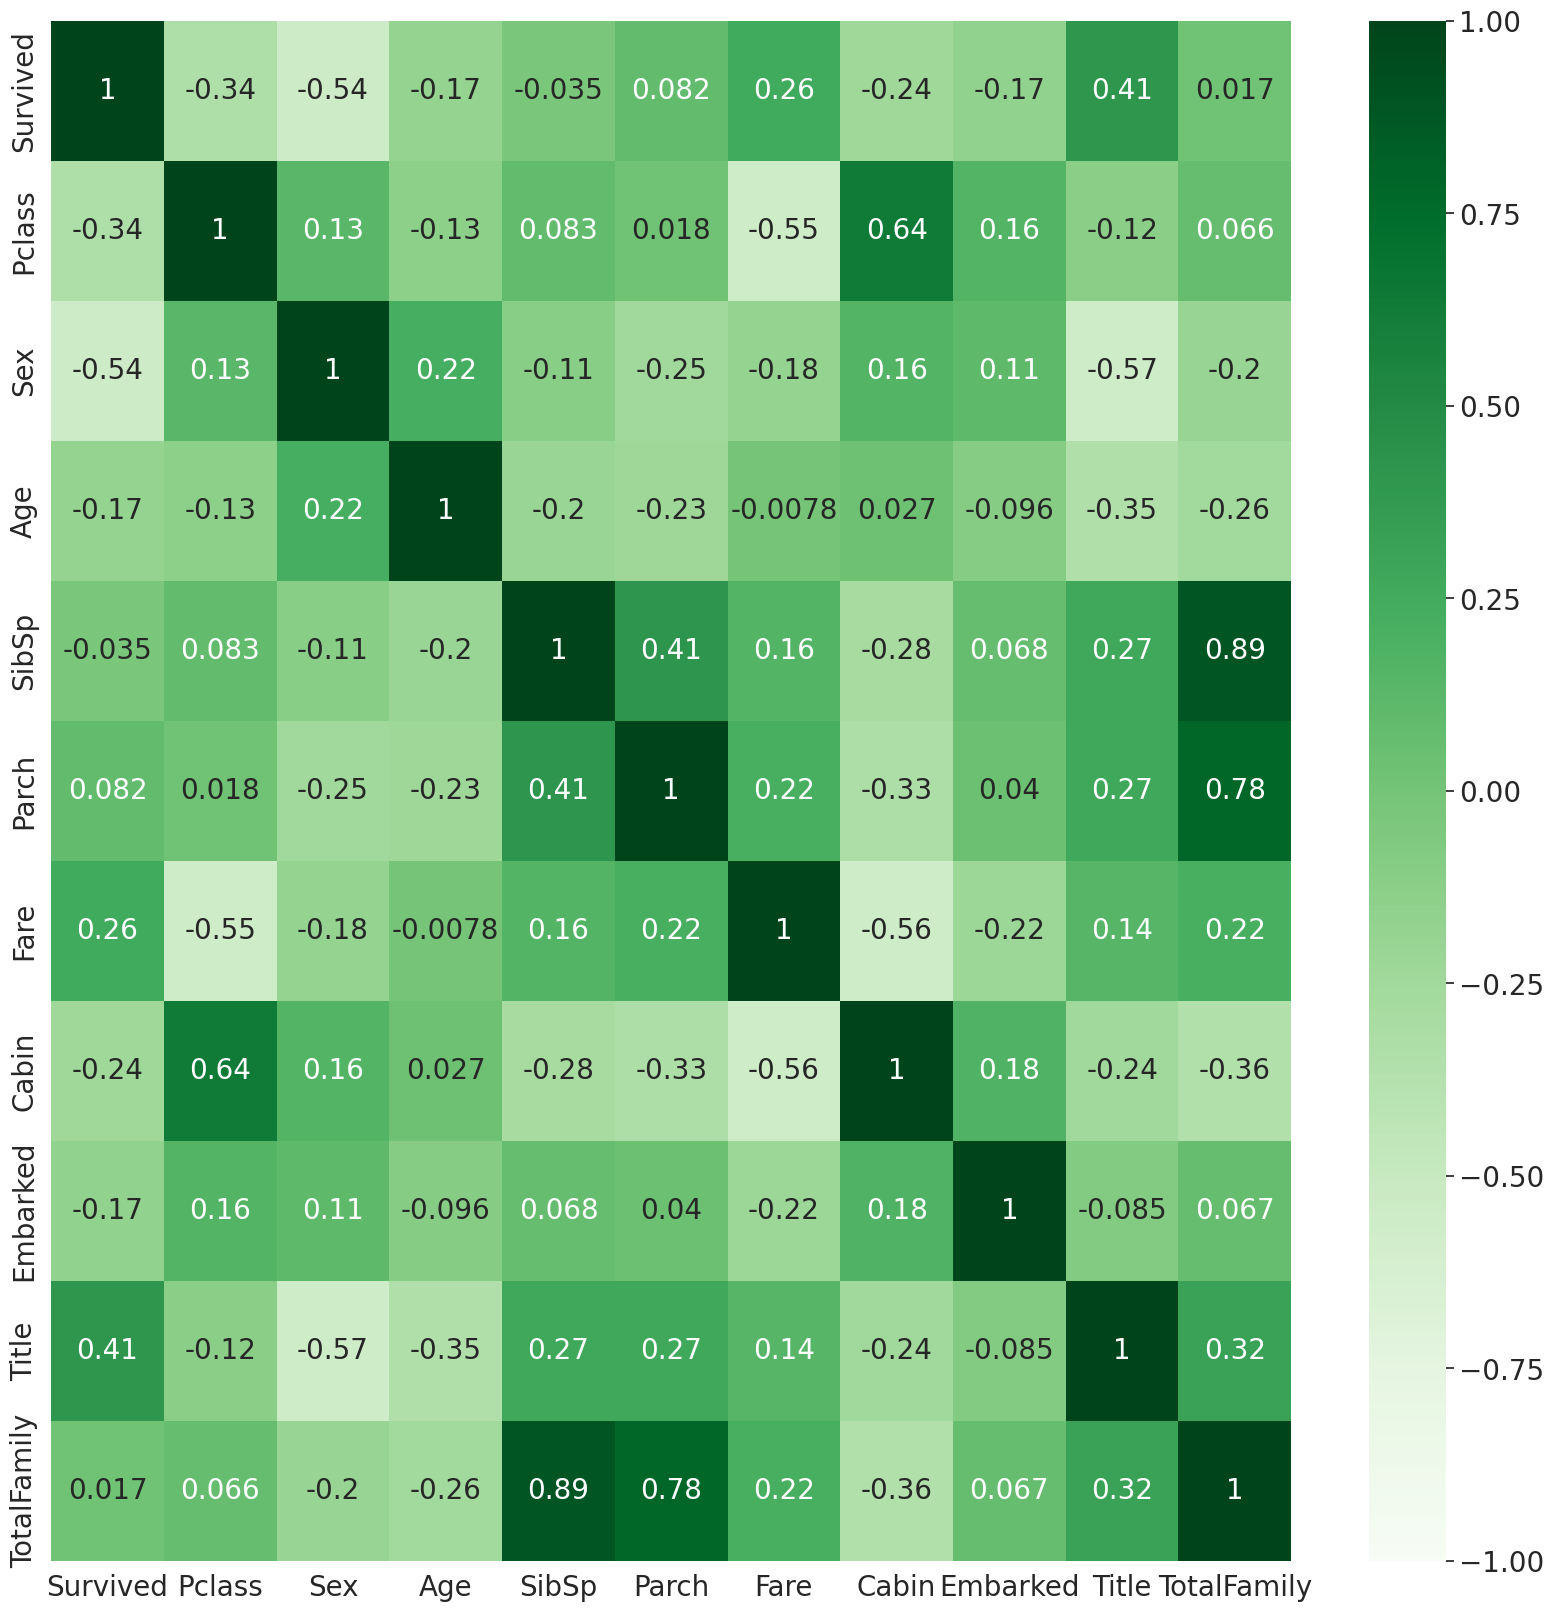

In [115]:
# Filter out non-numeric columns
numeric_columns = train.select_dtypes(include=['number']).columns

# Calculate correlation only for numeric columns
cor = train[numeric_columns].corr()

# Create the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Greens, vmin=-1, vmax=1)
plt.show()

There is no high correlation here, but it seems that there is some connection between the **Fare**, **Pclass**, **Sex** and **Title** to the **Survivel** rate, although very small.  
Additionally there is some correlation between **Cabin** to **Pclass**.  
Les's check it out.

## Sex

1    577
0    314
Name: Sex, dtype: int64

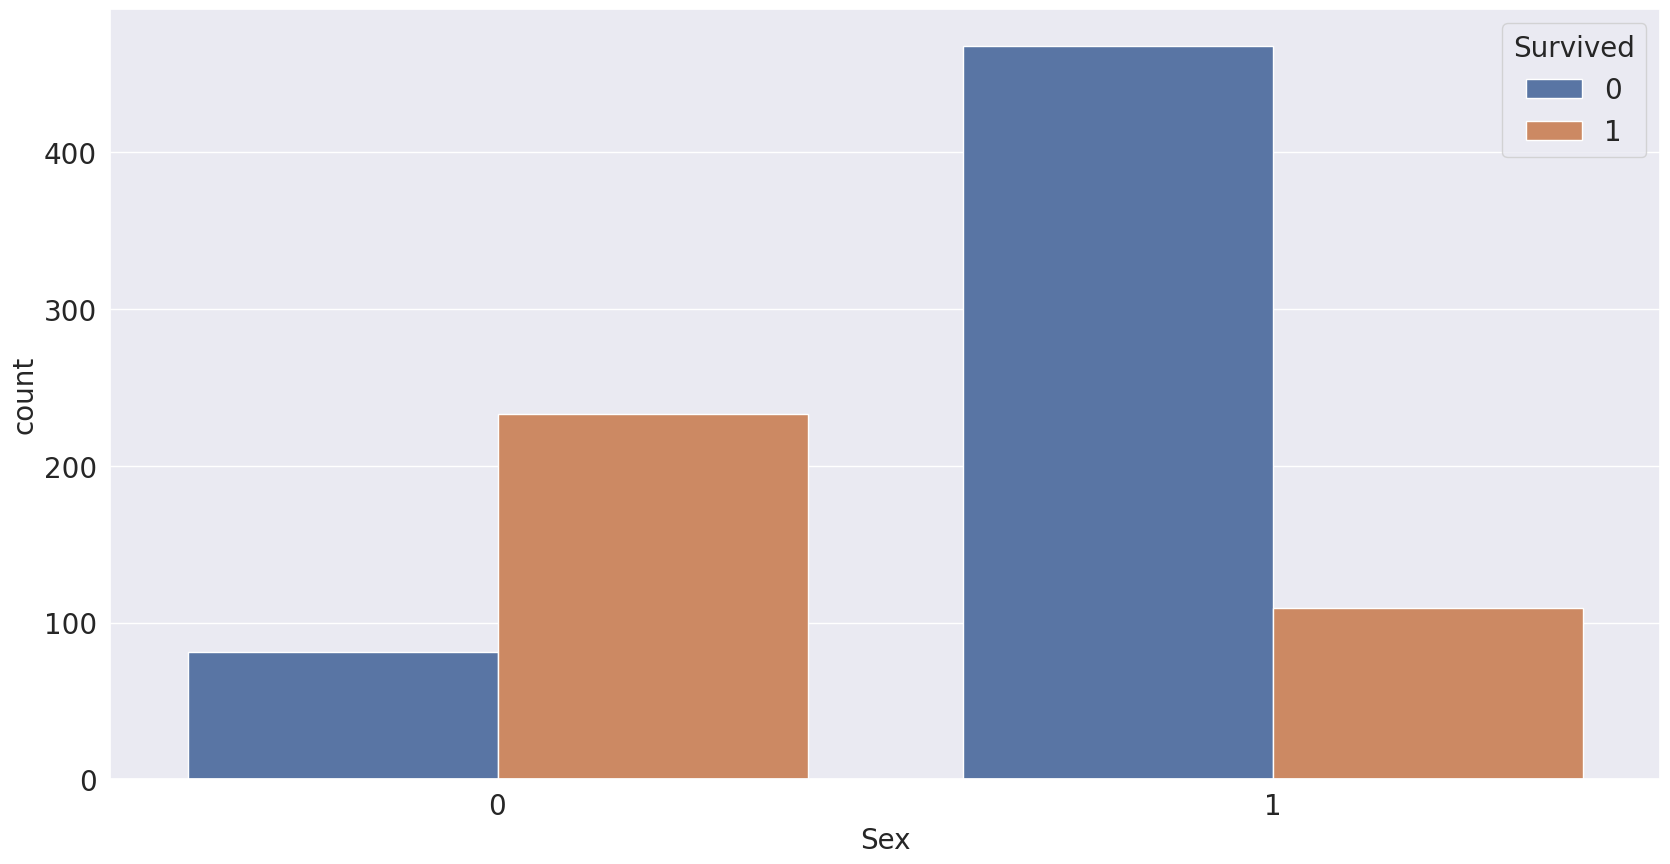

In [116]:
sns.countplot(x="Sex", hue="Survived", data=train)
train['Sex'].value_counts()

The plot shows us that more female survivels then male survivels, Even though there were more men on the ship. I guess they evacuated the females before the males to the lifeboats.

## Fare

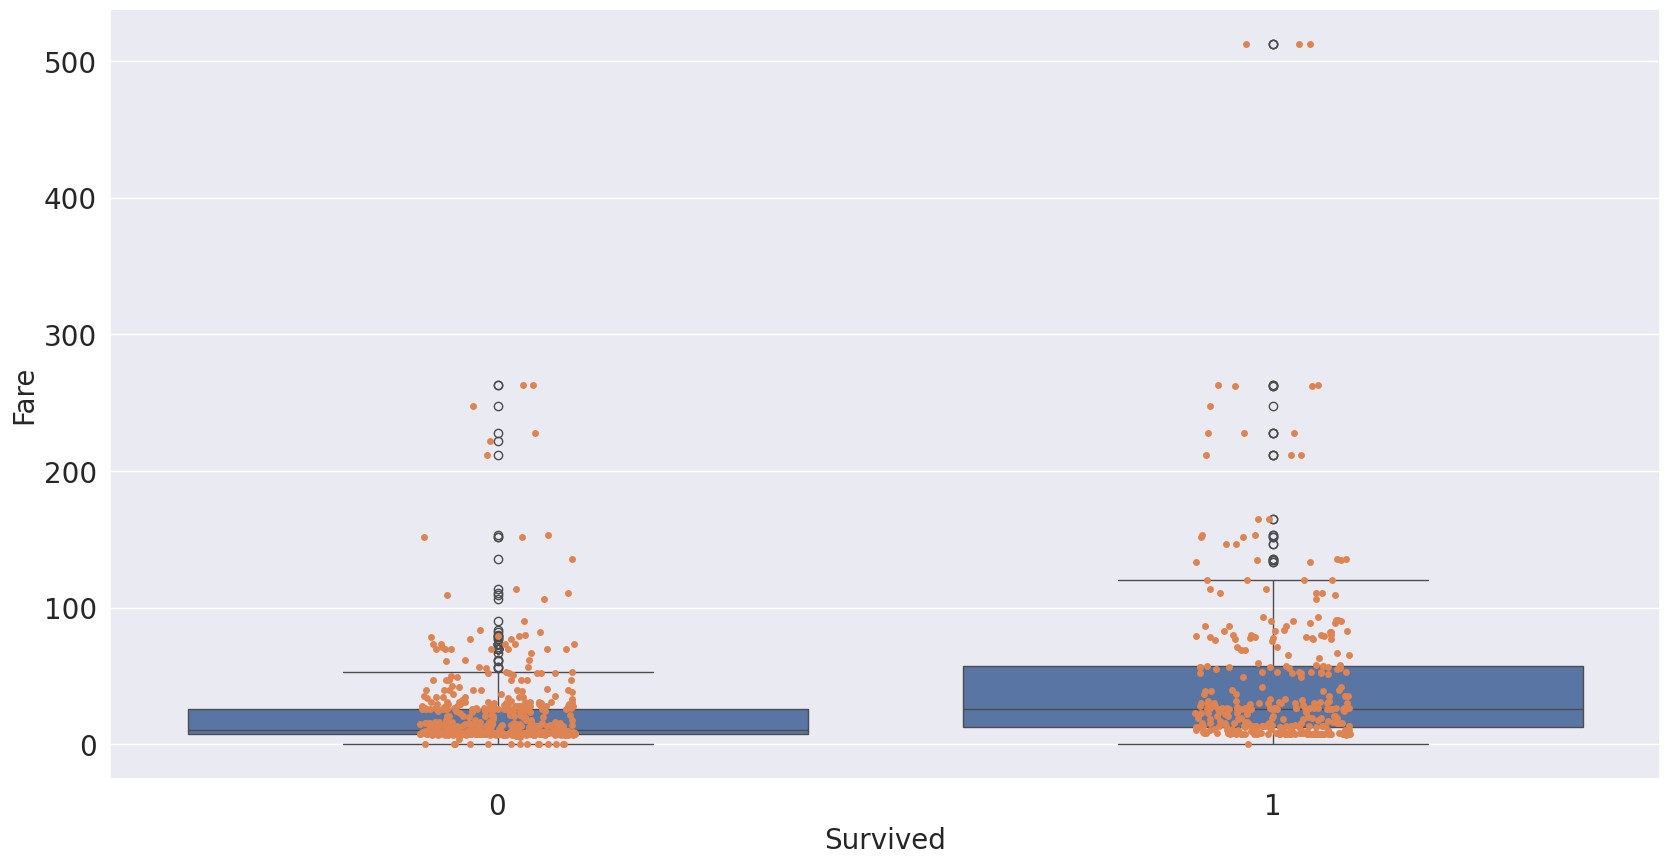

In [117]:
with pd.option_context('mode.use_inf_as_na', True):
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(x="Survived", y="Fare", data=train)
    # shows the data samples:
    sns.stripplot(x="Survived", y="Fare", data=train)

<Axes: xlabel='Survived', ylabel='Fare'>

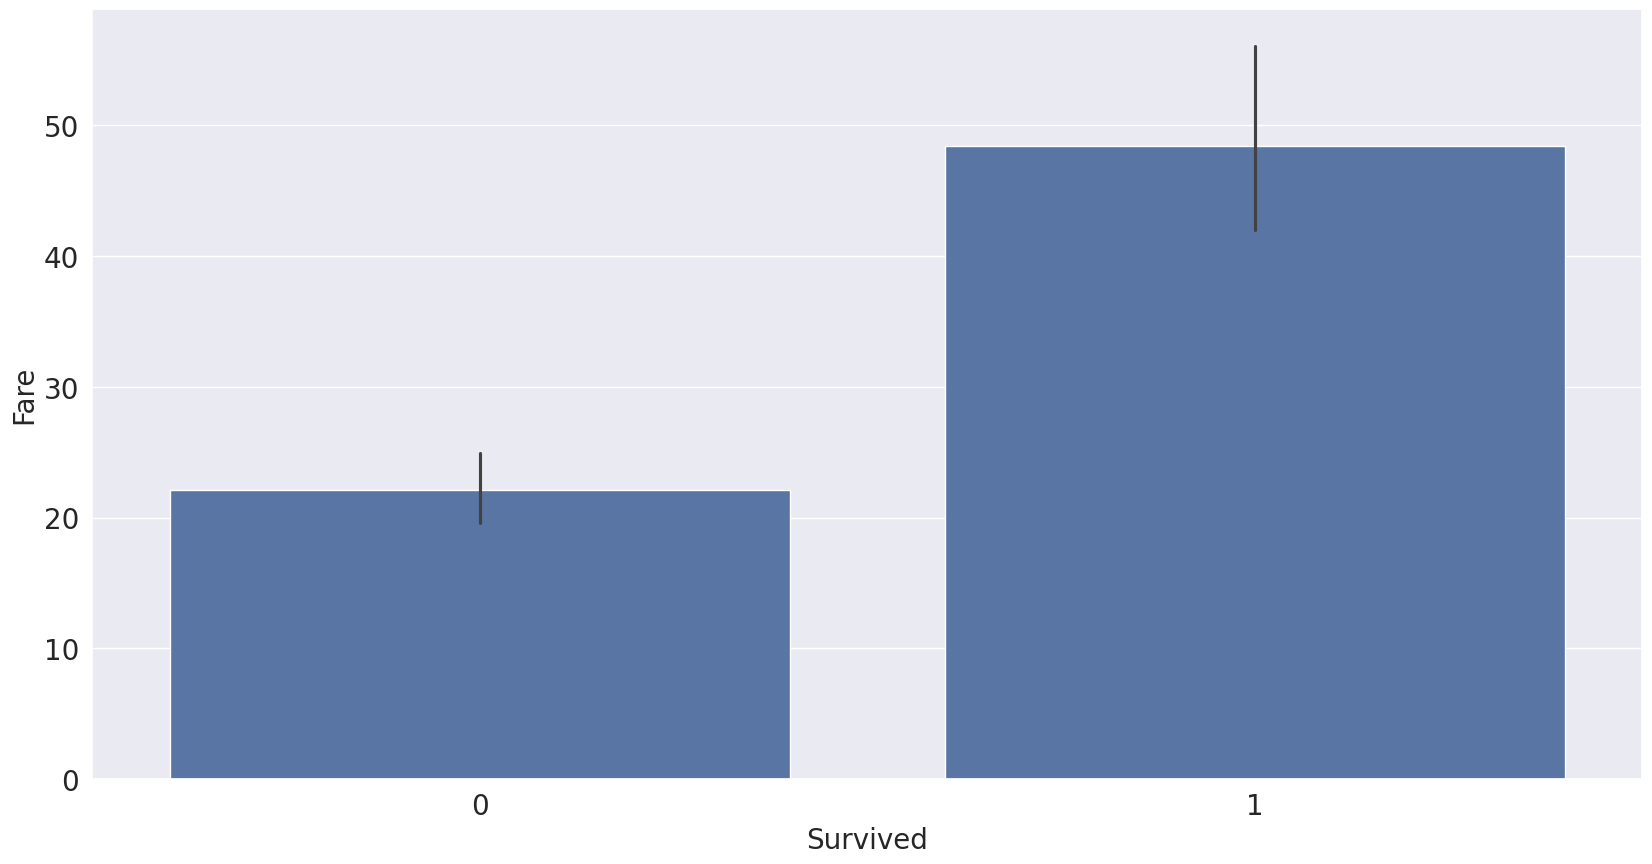

In [118]:
sns.barplot(x=train['Survived'],y=train['Fare'])


Based on this graph, you can see that the probability of surviving a person with a more expensive ticket is much greater.

## Pclass

<Axes: xlabel='Pclass', ylabel='count'>

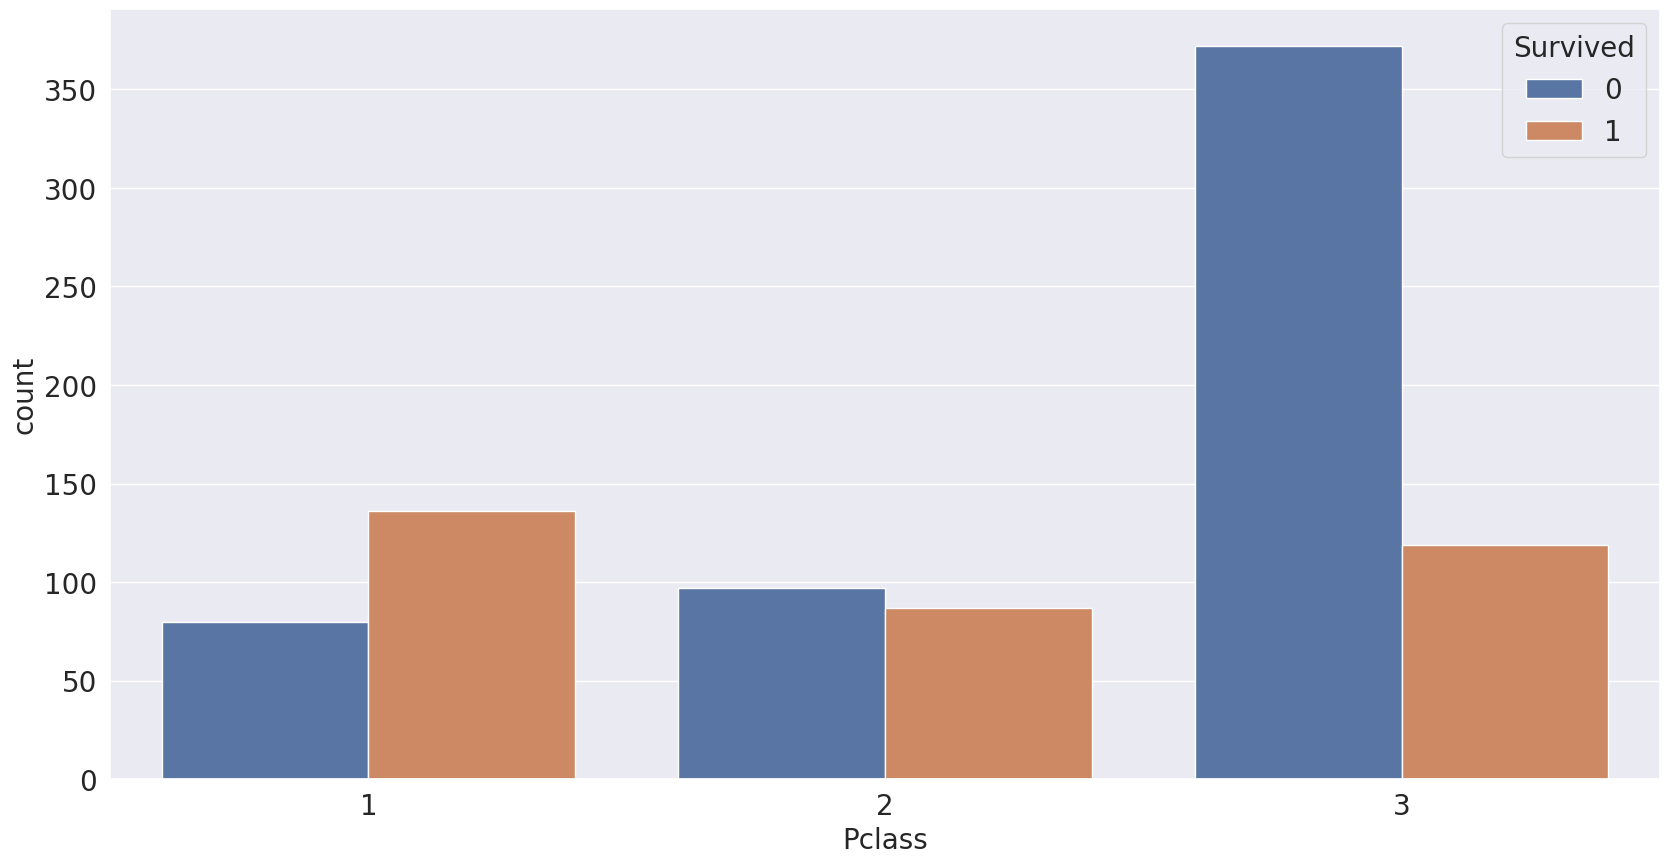

In [119]:
sns.countplot(x="Pclass", hue="Survived", data=train)

The plot tells us that there are a lot of people that did not survive from the third class.
Maybe that's why when the fair is high there are more people that survived(Paid more for the more expensive classes).
But in this case i guess there were more people on the third class, and that explains why so many did not survive there.


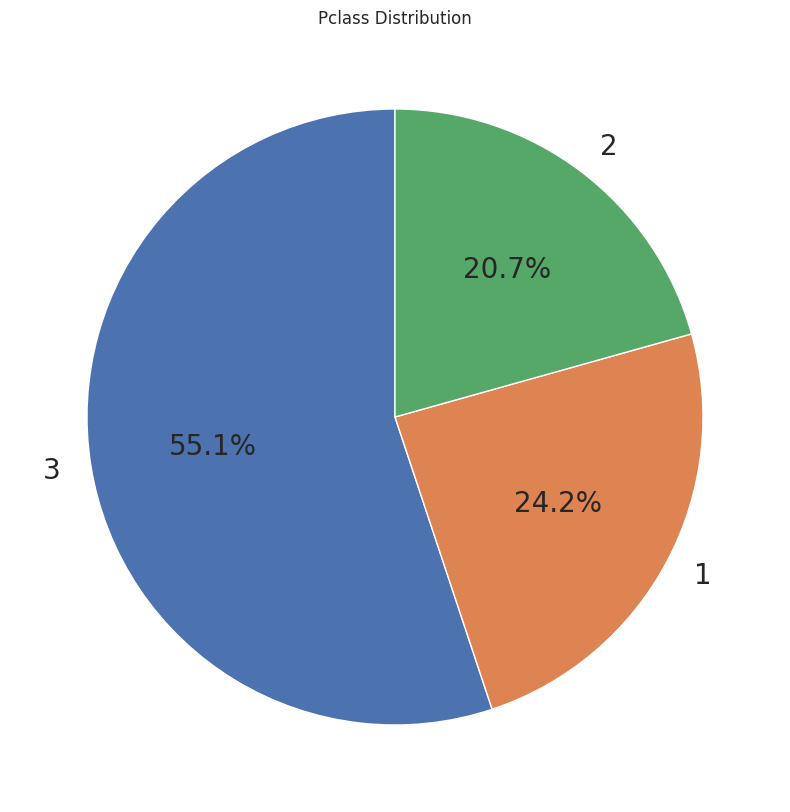

In [120]:
create_pie_chart_of_count(train, 'Pclass', 'Pclass Distribution')

Yes, that's probably the reason, the rate of people from the third class is the highest. This explains the high death toll and why the percentage of those who paid more fair survived more.

## Title

<Axes: xlabel='Title', ylabel='count'>

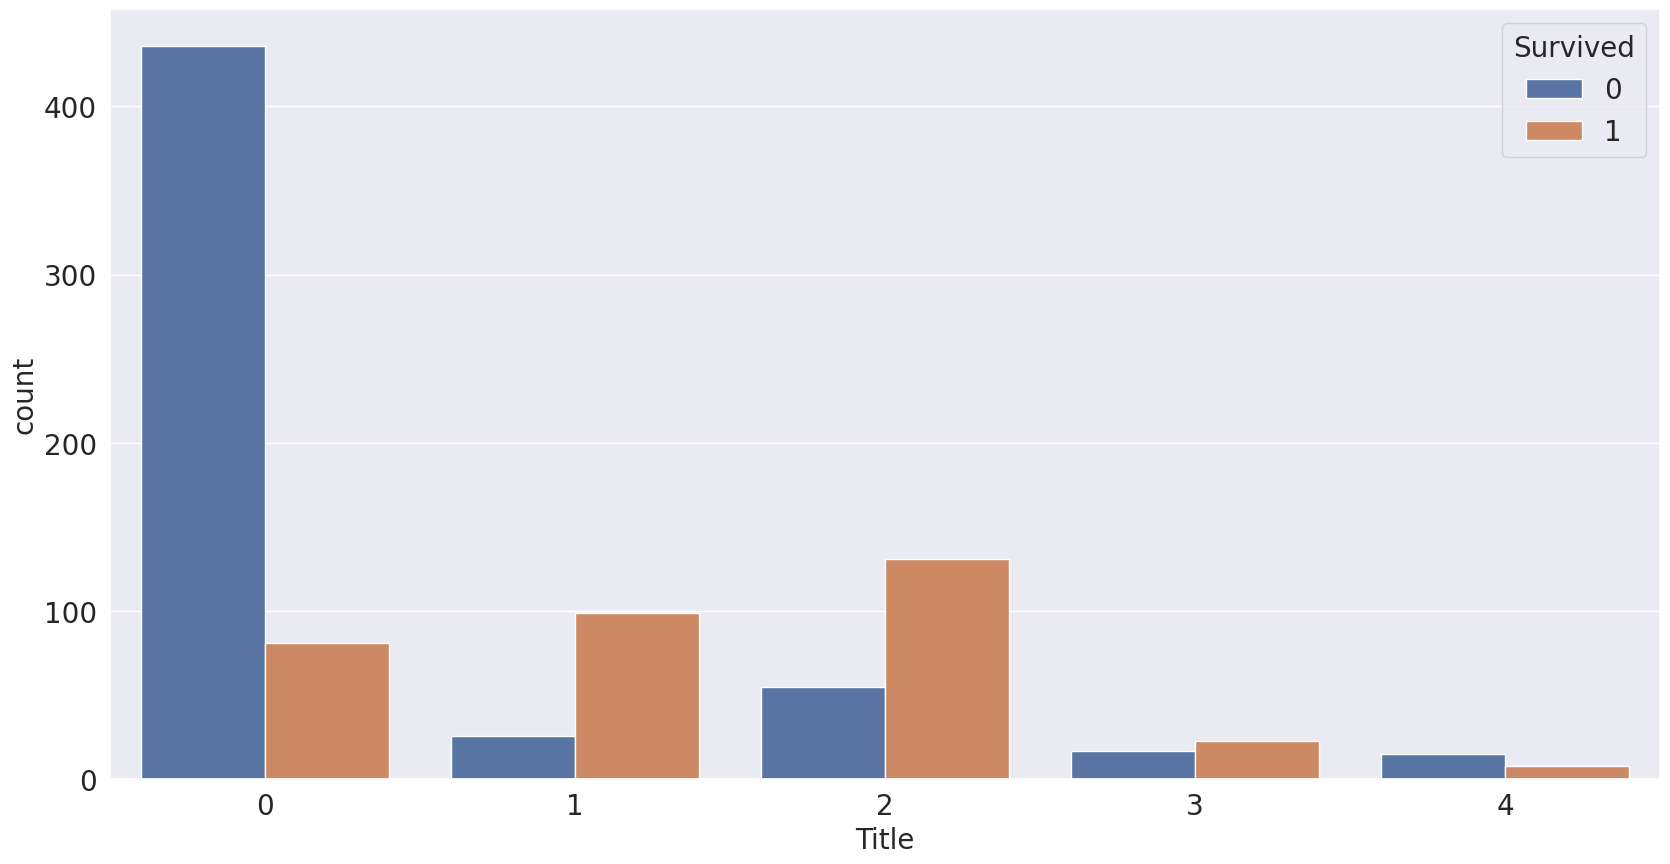

In [121]:
sns.countplot(x="Title", hue="Survived", data=train)

* a lot of people with the title "Mr" not survived.
* We know that more men died than women.
* "Mr" is the common name for an unmarried man.

## Title

<Axes: xlabel='Cabin', ylabel='count'>

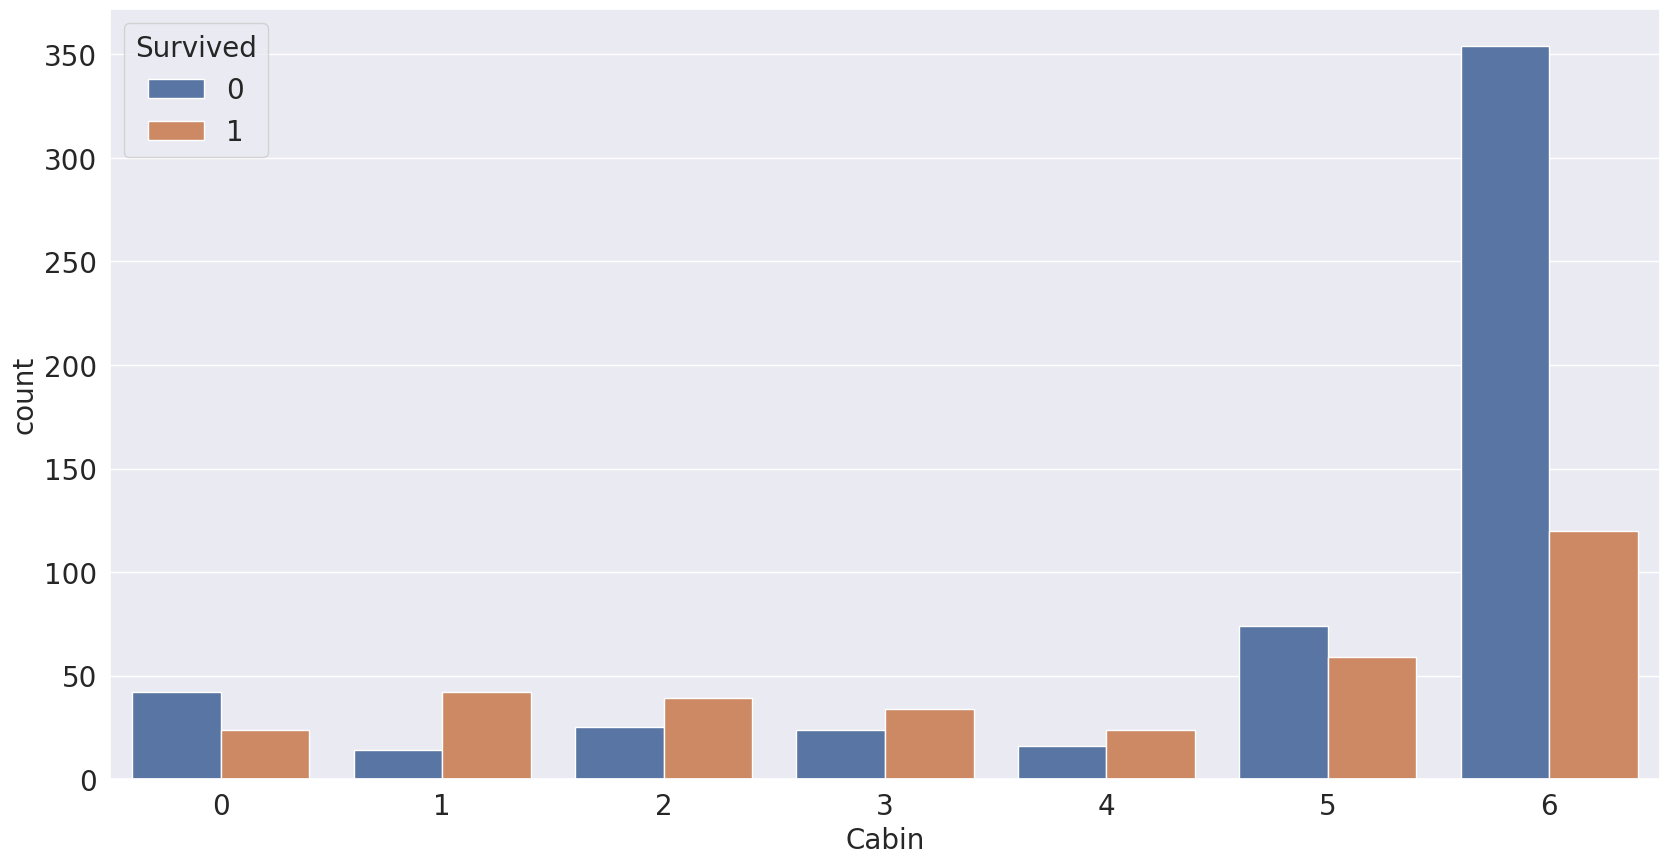

In [122]:
sns.countplot(x="Cabin", hue="Survived", data=train)


* Many people were killed in cabin F and G groups.
* I guess they were from third class

# Additional features  
We will try to create a features that increases the chances of survival,
We will call him SPF, it includes anyone who is a female, in first or second class and also paid fair above average.  
In addition I add a variable that multiplies between Pclass and Cabin called "Pclass * Cabin" for research purposes.

In [123]:
# show absolute correlation between features (with the new size feature) in a heatmap
train_copy = train.copy()
train_copy['SPF'] = (train_copy['Sex'] == 0) & ((train_copy['Pclass'] == 1) | (train_copy['Pclass'] == 2)) & (train_copy['Fare'] > train_copy['Fare'].median())
train_copy['Pclass * Cabin'] = (train_copy['Pclass'] * train_copy['Cabin'])


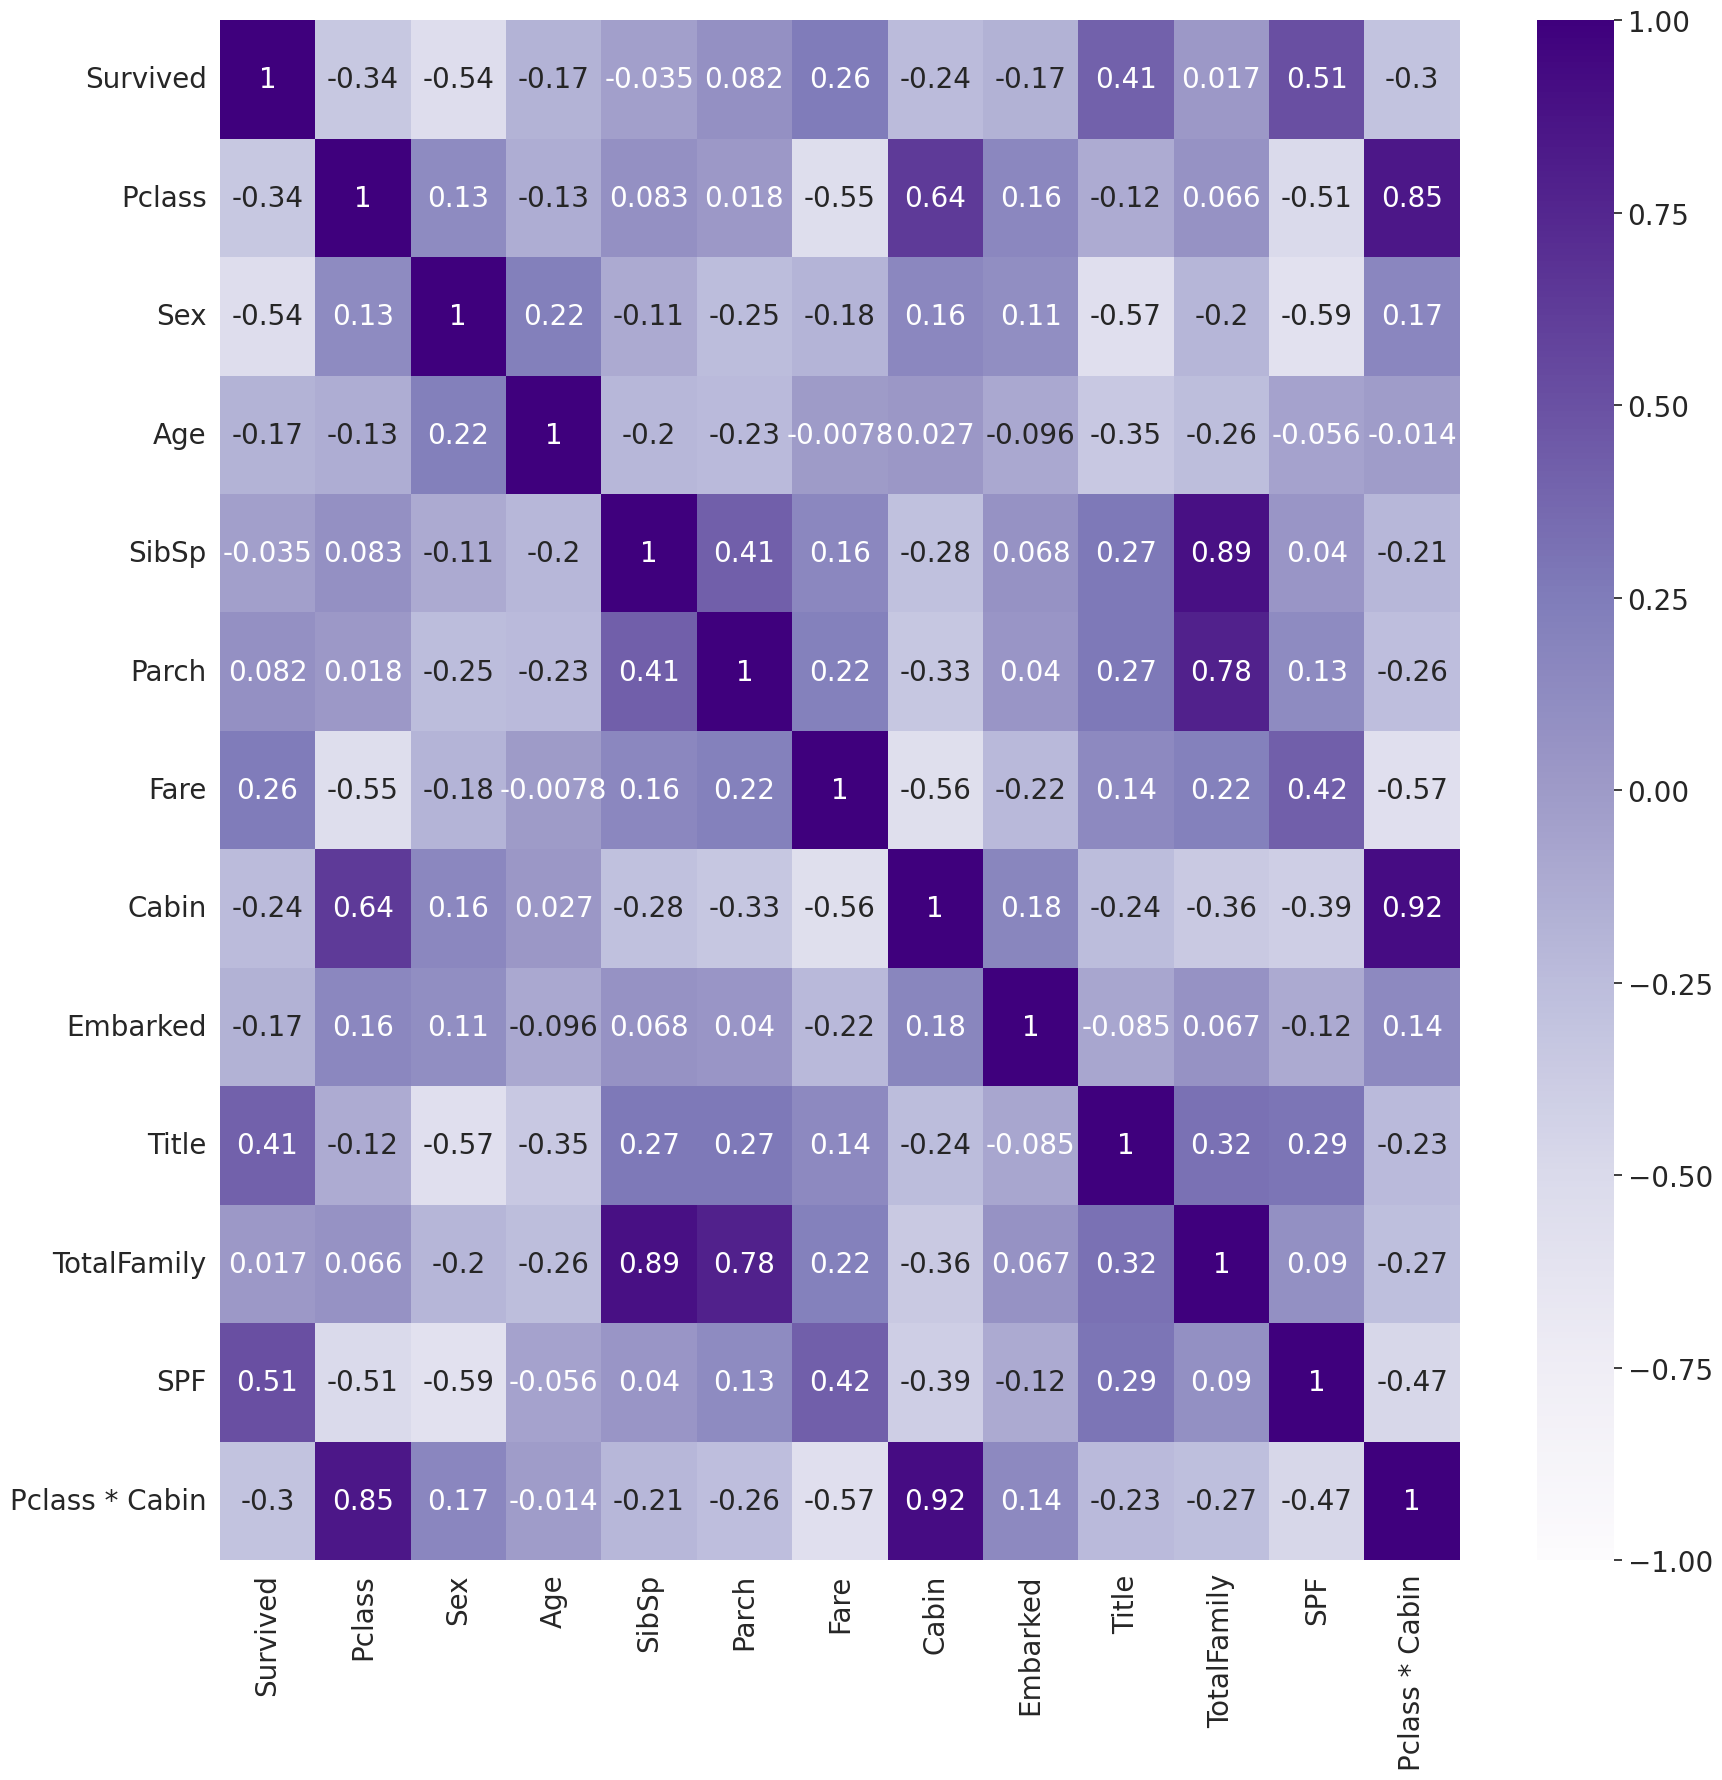

In [124]:
plt.figure(figsize=(20,20))
cor = train_copy.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Purples,
            vmin=-1, vmax=1)
plt.show()

* The figure SPF has 0.51 correlation Low, but relatively high to the other Features.
* In ״Pclass * Cabin״ I don't see anything special.

# Accuracy - Logistic Regression or MPL

In [125]:
# divide the train data to features and target
t = train['Survived'].copy()
x = train.drop(['Survived'], axis=1)
t_cp = train_copy['Survived']
X_cp = train_copy.drop('Survived', axis=1)

In [126]:
# print 4 graphs: ce of train/test and r2 of train/test
def print_graphs_r2_ce(graph_points):
  for k, v in graph_points.items():
    best_value = max(v.values()) if 'R2' in k else min(v.values())
    best_index = np.argmax(list(v.values())) if 'R2' in k else np.argmin(list(v.values()))
    color = 'r' if 'train' in k else 'b'
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(list(v.keys()), list(v.values()), color)
    plt.grid()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'{k}, best value: x={best_index + 1}, y={best_value}', fontsize=20)
    plt.show()

In [127]:
# plot the score by split and the loss by split for SGD
def plot_score_and_loss_by_split_SGD(x, t):
  graph_points = { 'train_CE': {}, 'val_CE': {}, 'train_R2': {}, 'val_R2': {} }

  for size in range(10, 100, 10):
    x_train, x_val, t_train, t_val = model_selection.train_test_split(x, t, test_size=size/100, random_state=42)
    SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log_loss', alpha=0, learning_rate='constant', eta0=0.01)).fit(x_train, t_train)
    #SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log', alpha=0, learning_rate='constant', eta0=0.01)).fit(x_train, t_train)
    y_train_prob = SGD_cls.predict_proba(x_train)
    y_test_prob = SGD_cls.predict_proba(x_val)
    y_train = SGD_cls.predict(x_train)
    y_val = SGD_cls.predict(x_val)
    graph_points['train_CE'][size/100] = metrics.log_loss(t_train, y_train_prob)
    graph_points['val_CE'][size/100] = metrics.log_loss(t_val, y_test_prob)
    graph_points['train_R2'][size/100] = SGD_cls.score(x_train, t_train)
    graph_points['val_R2'][size/100] = SGD_cls.score(x_val, t_val)
  print_graphs_r2_ce(graph_points)

In [128]:
# plot the score by split and the loss by split for MLP
def plot_score_and_loss_by_split_MLP(x, t):
  graph_points = { 'train_CE': {}, 'val_CE': {}, 'train_R2': {}, 'val_R2': {} }

  for size in range(10, 100, 10):
    x_train, x_val, t_train, t_val = model_selection.train_test_split(x, t, test_size=size/100, random_state=42)
    MLP_cls = neural_network.MLPClassifier(activation='logistic', solver='sgd', alpha=0, max_iter=40000).fit(x_train, t_train)
    y_train_prob = MLP_cls.predict_proba(x_train)
    y_test_prob = MLP_cls.predict_proba(x_val)
    graph_points['train_CE'][size/100] = metrics.log_loss(t_train, y_train_prob)
    graph_points['val_CE'][size/100] = metrics.log_loss(t_val, y_test_prob)
    graph_points['train_R2'][size/100] = MLP_cls.score(x_train, t_train)
    graph_points['val_R2'][size/100] = MLP_cls.score(x_val, t_val)
  print_graphs_r2_ce(graph_points)

**SGD Classifier Model**

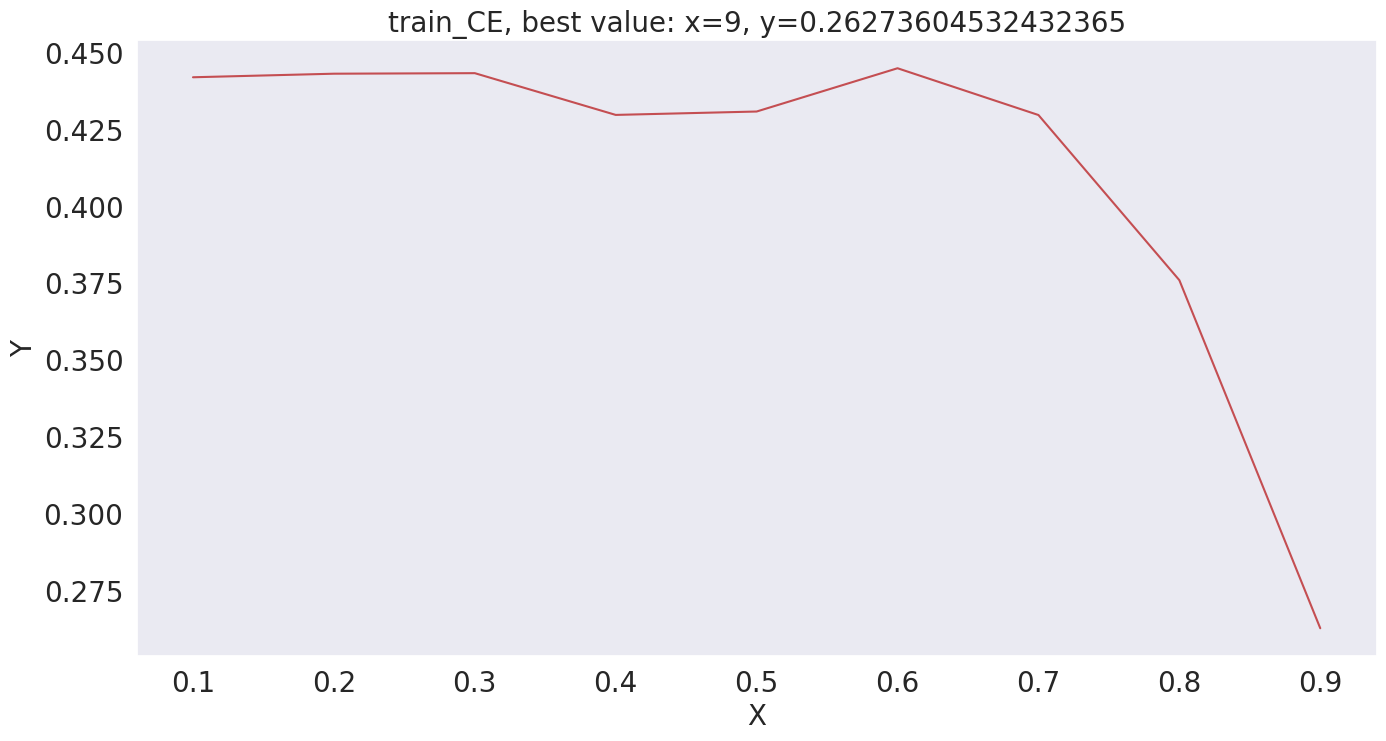

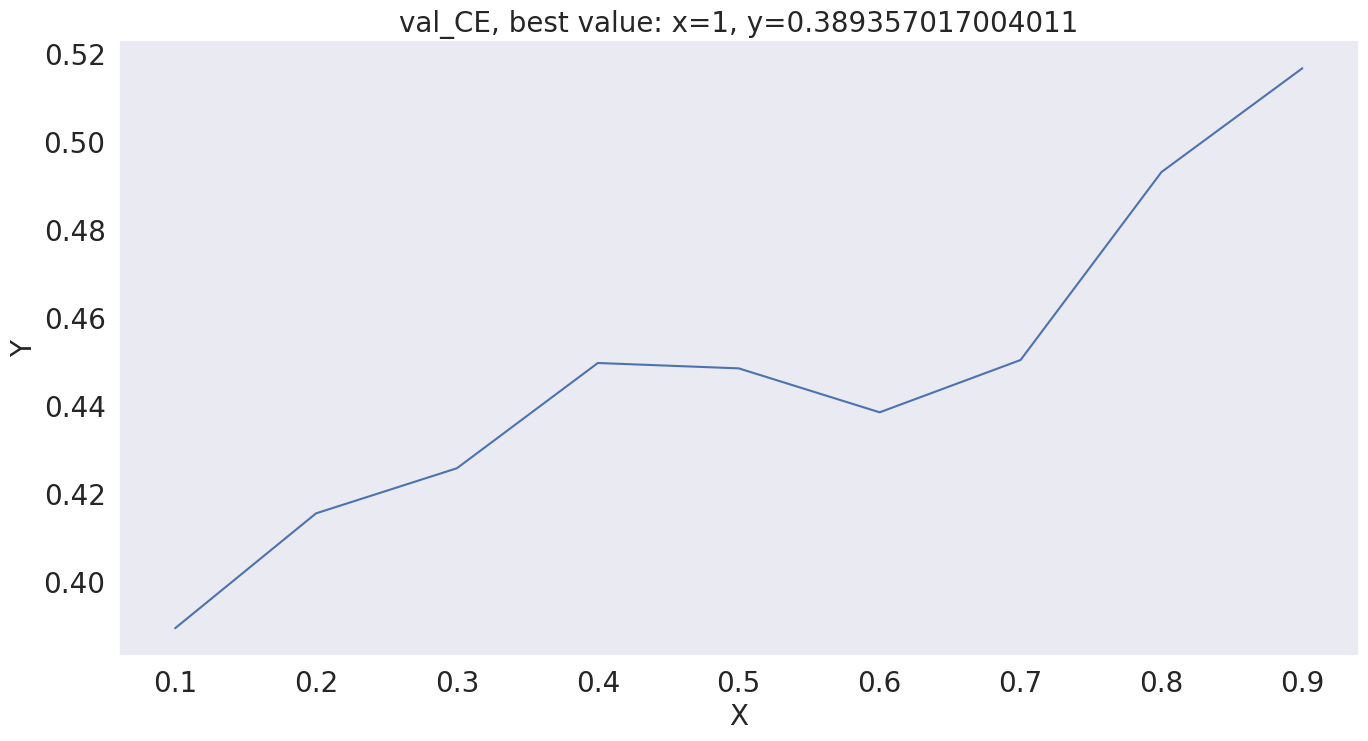

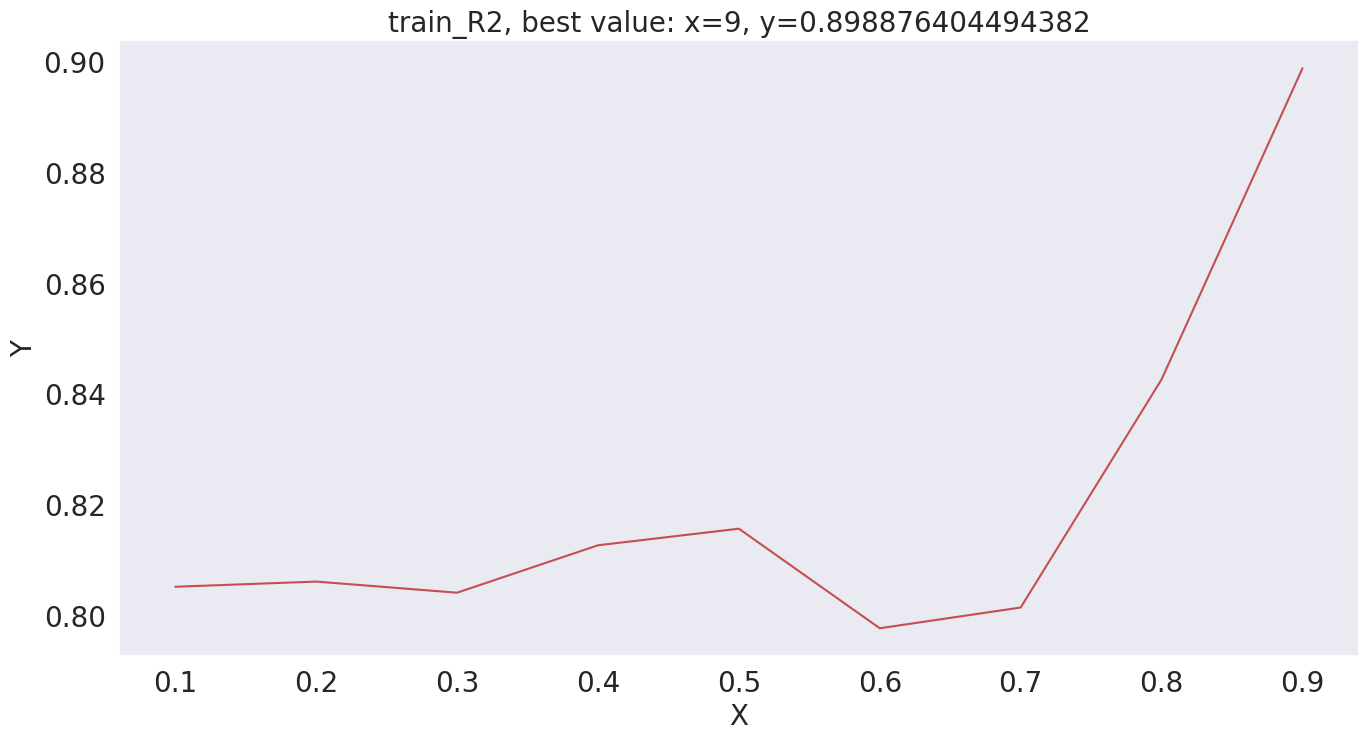

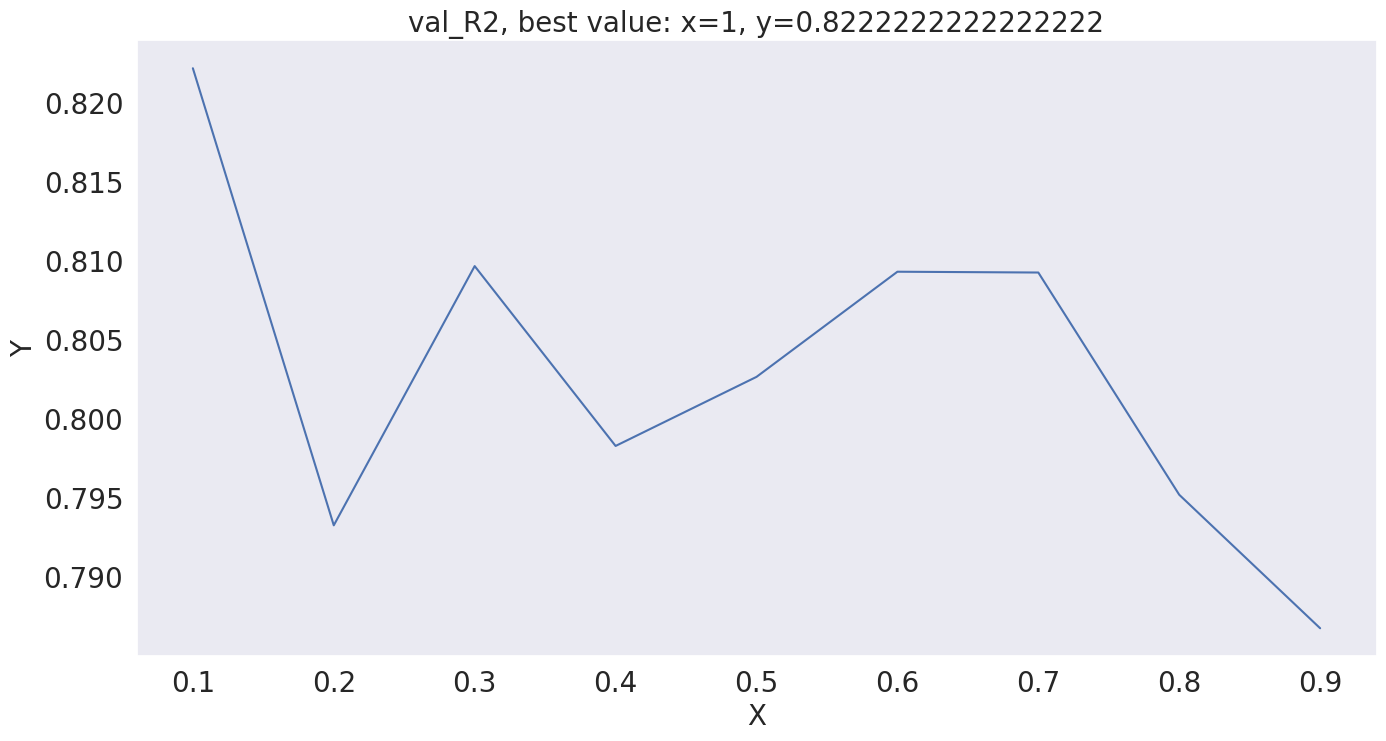

In [129]:
plot_score_and_loss_by_split_SGD(x, t)

**MLP**

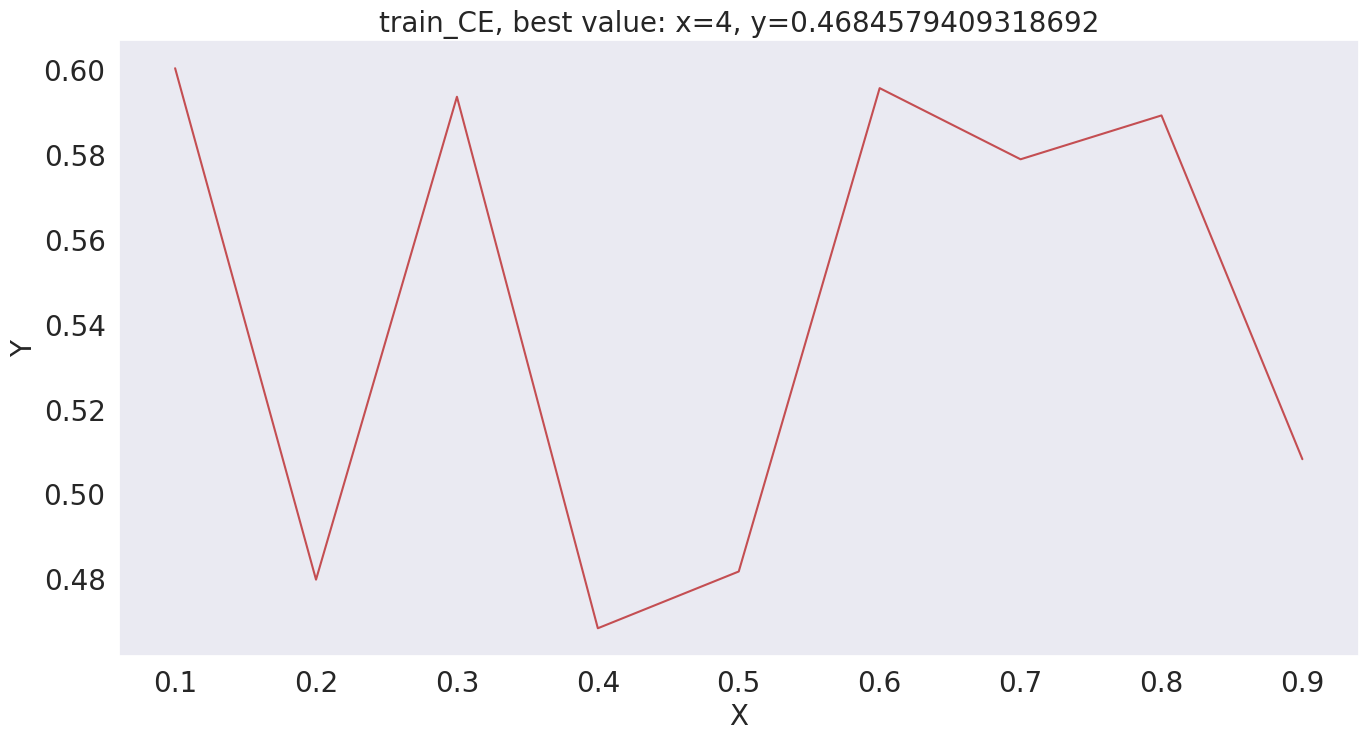

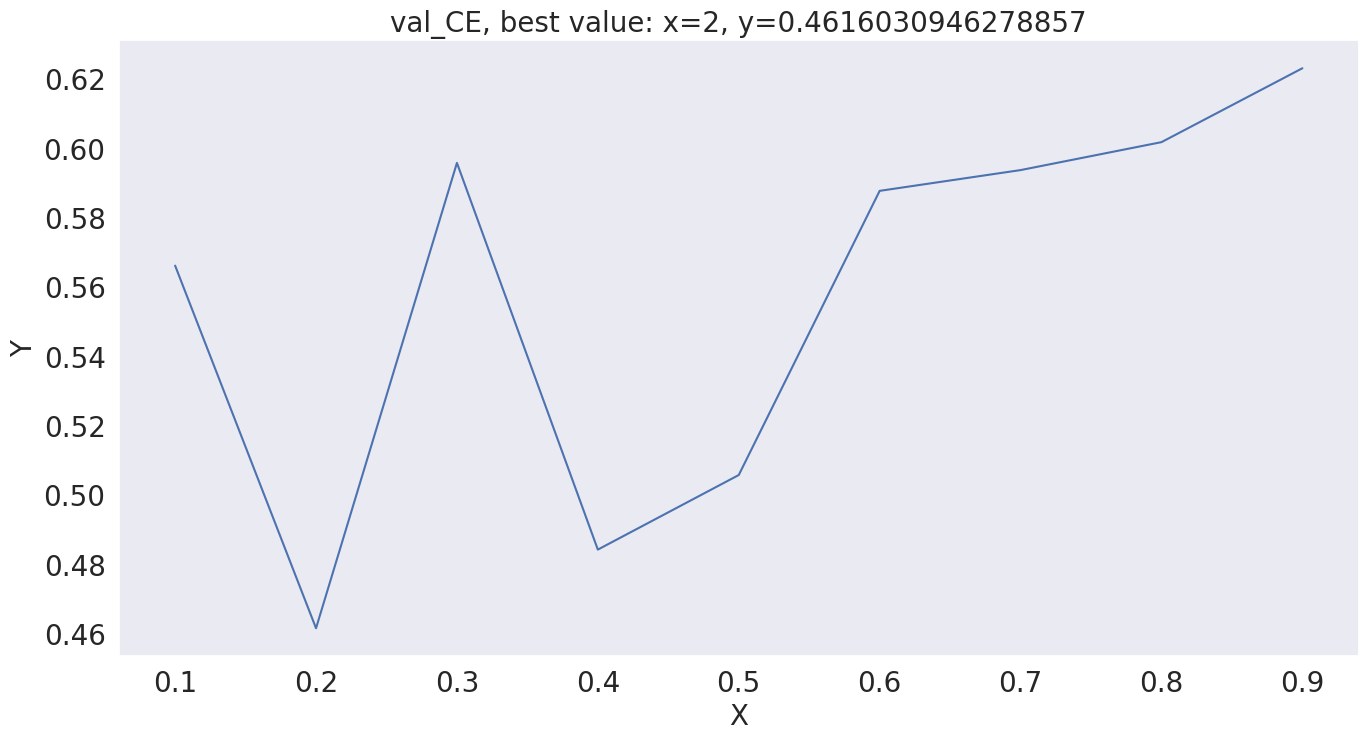

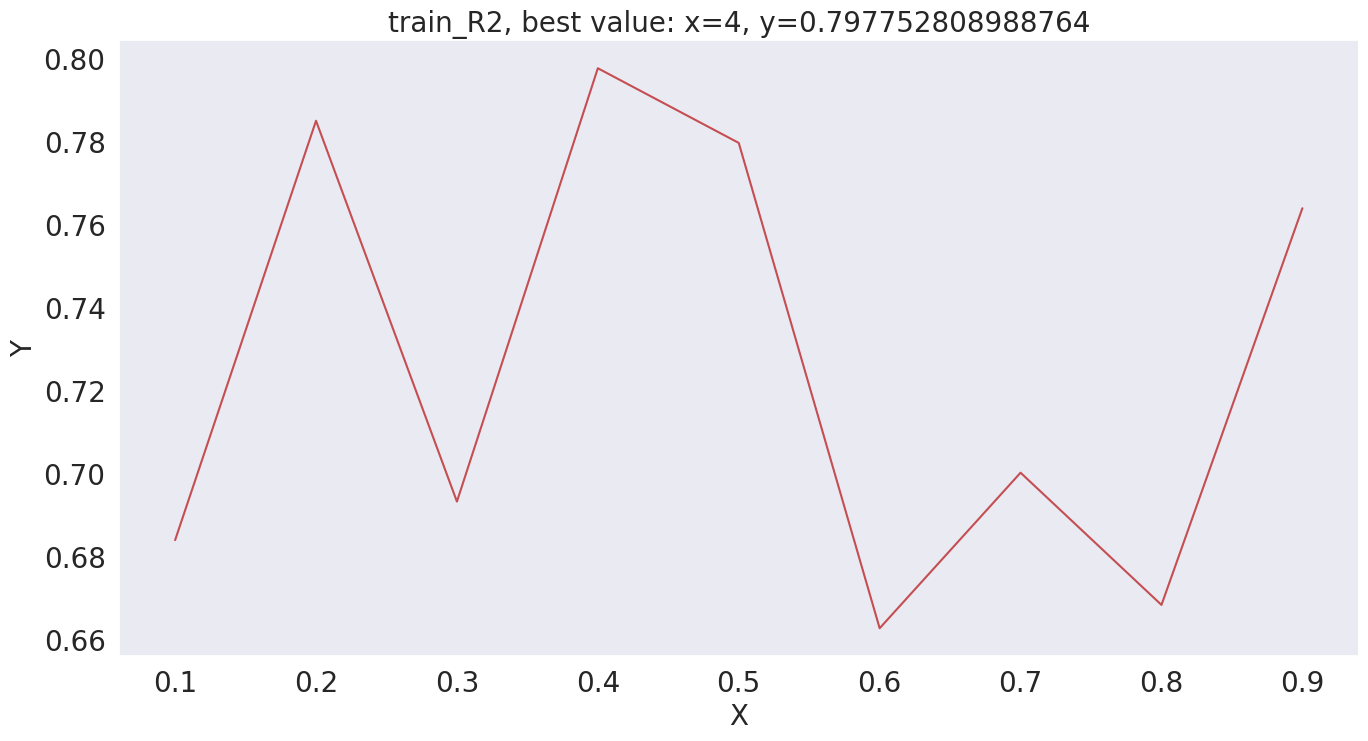

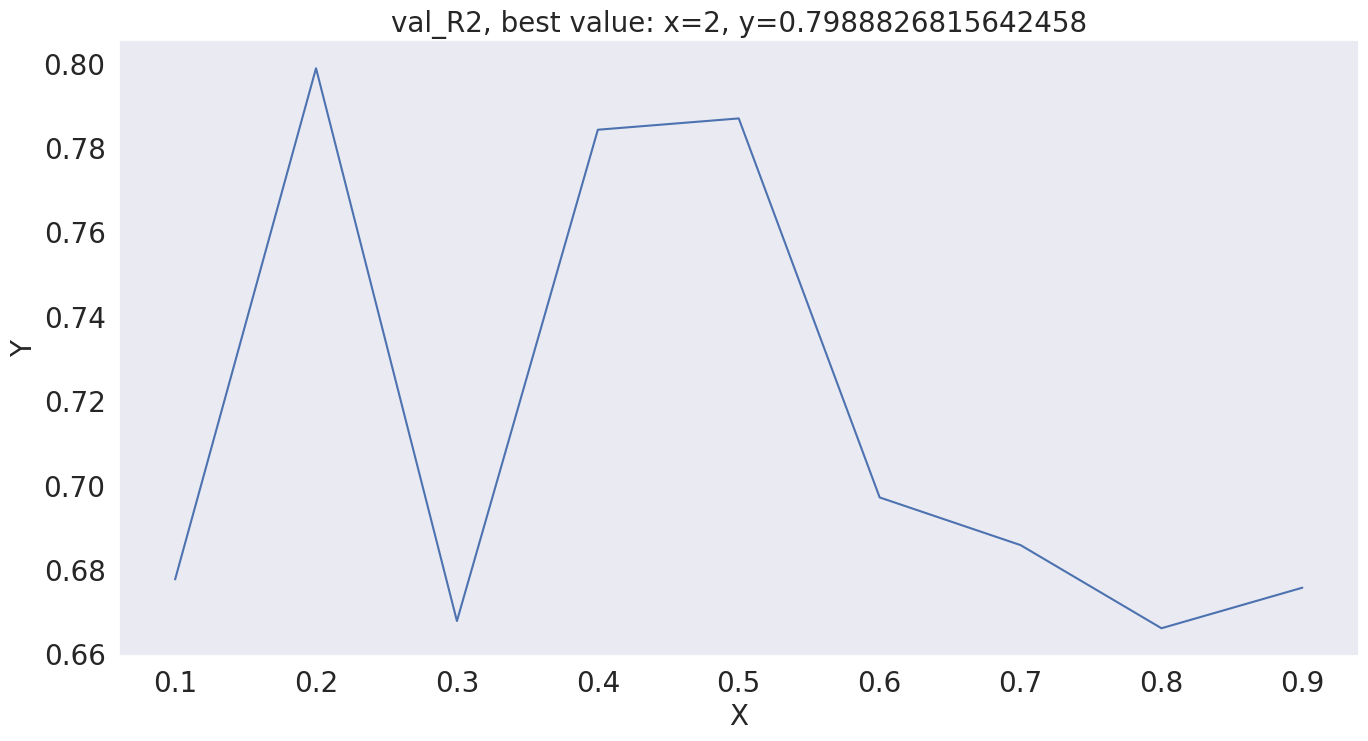

In [130]:
plot_score_and_loss_by_split_MLP(x, t)

As you can see, the logistic regression gives us a smaller error compared to the MLP.
So I use the SGDClassifierModel for the hypothesis.  
Let's compare it with the additonal features.

**SGD Classifier Model with the additonal features**

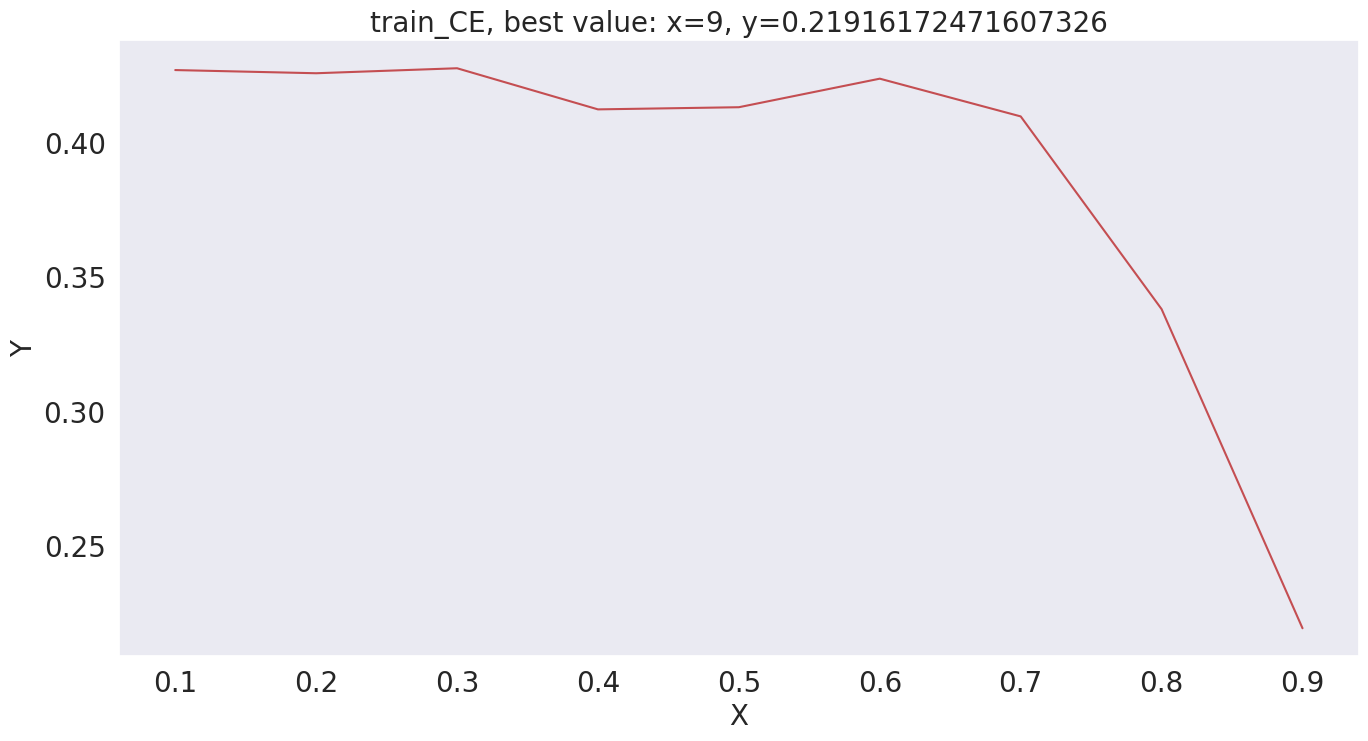

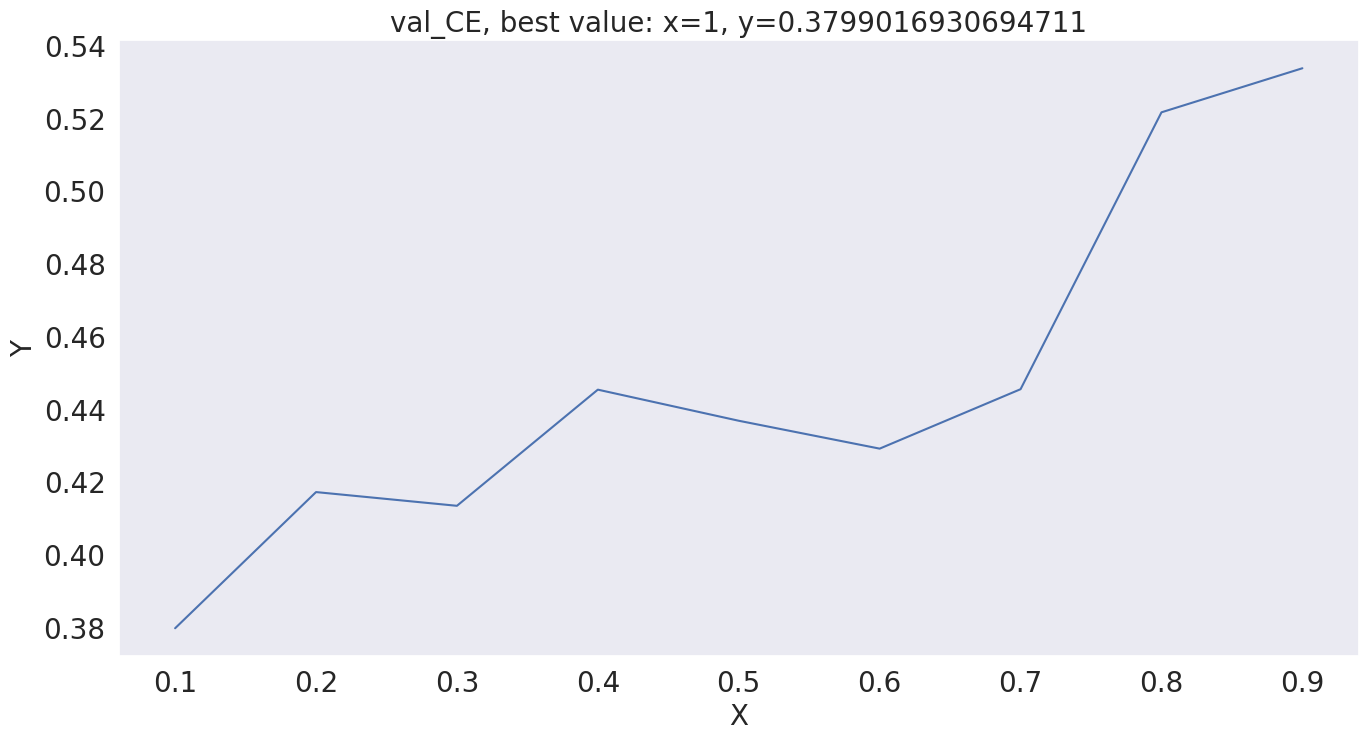

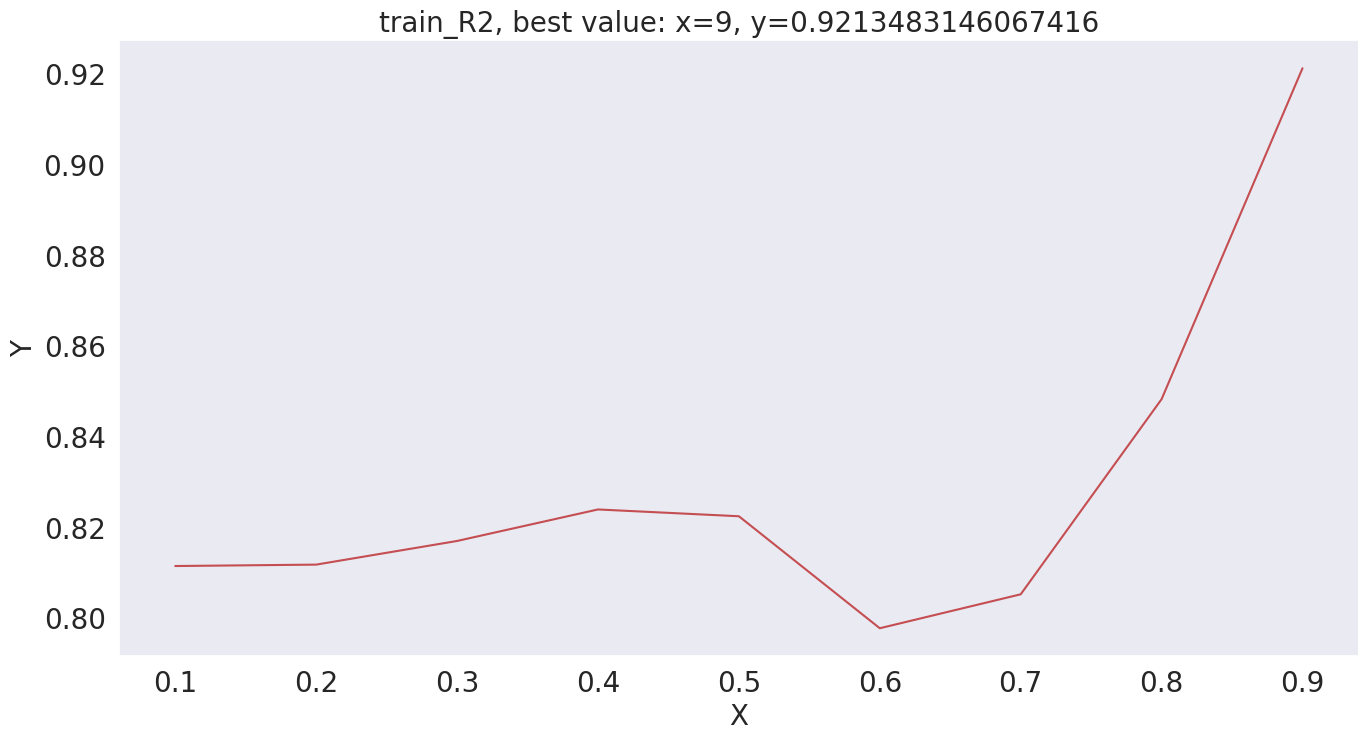

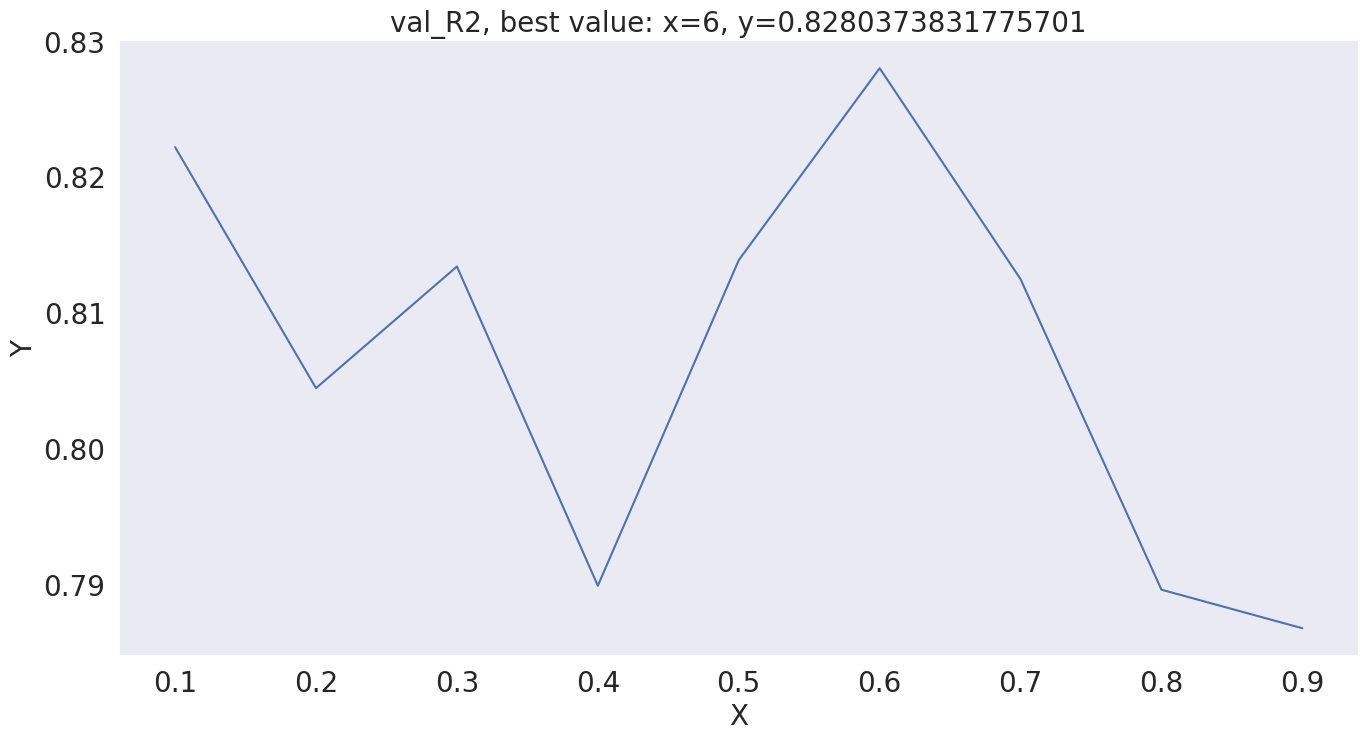

In [131]:
plot_score_and_loss_by_split_SGD(X_cp, t_cp)


it seems that SGD Classifier Model with the additonal feature is more accurate and has less CE then the others.

# Training the SGDClassifierModel

I split the data to 70% train and 30% test based on the graphs and after a few runs.

In [132]:
# split the data to 70% train and 30% test
t = train['Survived']
X = train.drop('Survived', axis=1)
X_train, X_test, t_train, t_test = sklearn.model_selection.train_test_split(X, t, test_size=0.3, random_state=42)

In [133]:
# create the SGDClassifier and predict the probabilities of the train and test data
SGD_cls = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
     linear_model.SGDClassifier(loss='log_loss', alpha=0,
                                learning_rate='constant',
                                eta0=0.01)
     ).fit(X_train, t_train)

# predict probabilities
y_train_prob = SGD_cls.predict_proba(X_train)
y_test_prob = SGD_cls.predict_proba(X_test)

# predicting test and train test results
y_train = SGD_cls.predict(X_train)
y_test = SGD_cls.predict(X_test)

# print the accuracy score and CE loss of the train and test
print('Accuracy score on train',SGD_cls.score(X_train, t_train))
print('Accuracy score on test',SGD_cls.score(X_test, t_test))
print()
print('CE on train',metrics.log_loss(t_train, y_train_prob))
print('CE on test', metrics.log_loss(t_test, y_test_prob))

Accuracy score on train 0.8009630818619583
Accuracy score on test 0.8134328358208955

CE on train 0.44353162568818405
CE on test 0.4237365242992841


# Train the Model on the Dataset with the additonal features
Let's check the results of the dataframe with the additional features.

In [134]:
# calculate accuracy and CE loss of the new dataframe (with the additional feature) train and test
X_train_cp, X_test_cp,\
t_train_cp, t_test_cp =\
sklearn.model_selection.train_test_split(
    X_cp, t_cp, test_size=0.30, random_state=42)

SGD_cls_cp = pipeline.make_pipeline(
    preprocessing.StandardScaler(),
     linear_model.SGDClassifier(
        loss='log_loss', alpha=0,
        learning_rate='constant', eta0=0.01)
     ).fit(X_train_cp, t_train_cp)

y_train_prob_cp = SGD_cls_cp.predict_proba(X_train_cp)
y_test_prob_cp = SGD_cls_cp.predict_proba(X_test_cp)

print('Accuracy score on train',
      SGD_cls_cp.score(X_train_cp, t_train_cp))
print('Accuracy score on test',
      SGD_cls_cp.score(X_test_cp, t_test_cp))
print()
print('CE on train',
      metrics.log_loss(t_train_cp, y_train_prob_cp))
print('CE on test',
      metrics.log_loss(t_test_cp, y_test_prob_cp))

Accuracy score on train 0.812199036918138
Accuracy score on test 0.8097014925373134

CE on train 0.4279121328403685
CE on test 0.41268240164970793


You can see from the results and the graph form the <-Accuracy-> that this model is more accurate and has less CE.

# Submission

In [136]:
submission = pd.read_csv("/content/gender_submission.csv")

test_copy = test.copy()
test_copy['SPF'] = train_copy['SPF'] = (train_copy['Sex'] == 0) & ((train_copy['Pclass'] == 1) | (train_copy['Pclass'] == 2)) & (train_copy['Fare'] > train_copy['Fare'].median())
test_copy['Pclass * Cabin'] = (train_copy['Pclass'] * train_copy['Cabin'])


# for the first model:
#SGD_cls = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log_loss', alpha=0, learning_rate='constant', eta0=0.01)).fit(x, t)
#submission_preds = SGD_cls.predict(test)

SGD_cls_cp = pipeline.make_pipeline(preprocessing.StandardScaler(), linear_model.SGDClassifier(loss='log_loss', alpha=0, learning_rate='constant', eta0=0.01)).fit(X_cp, t_cp)
submission_preds = SGD_cls_cp.predict(test_copy)

# create the submission file
submission['Survived'] = submission_preds
submission.to_csv('submission.csv', index=False)
submission

PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         1
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

# Kaggle Results

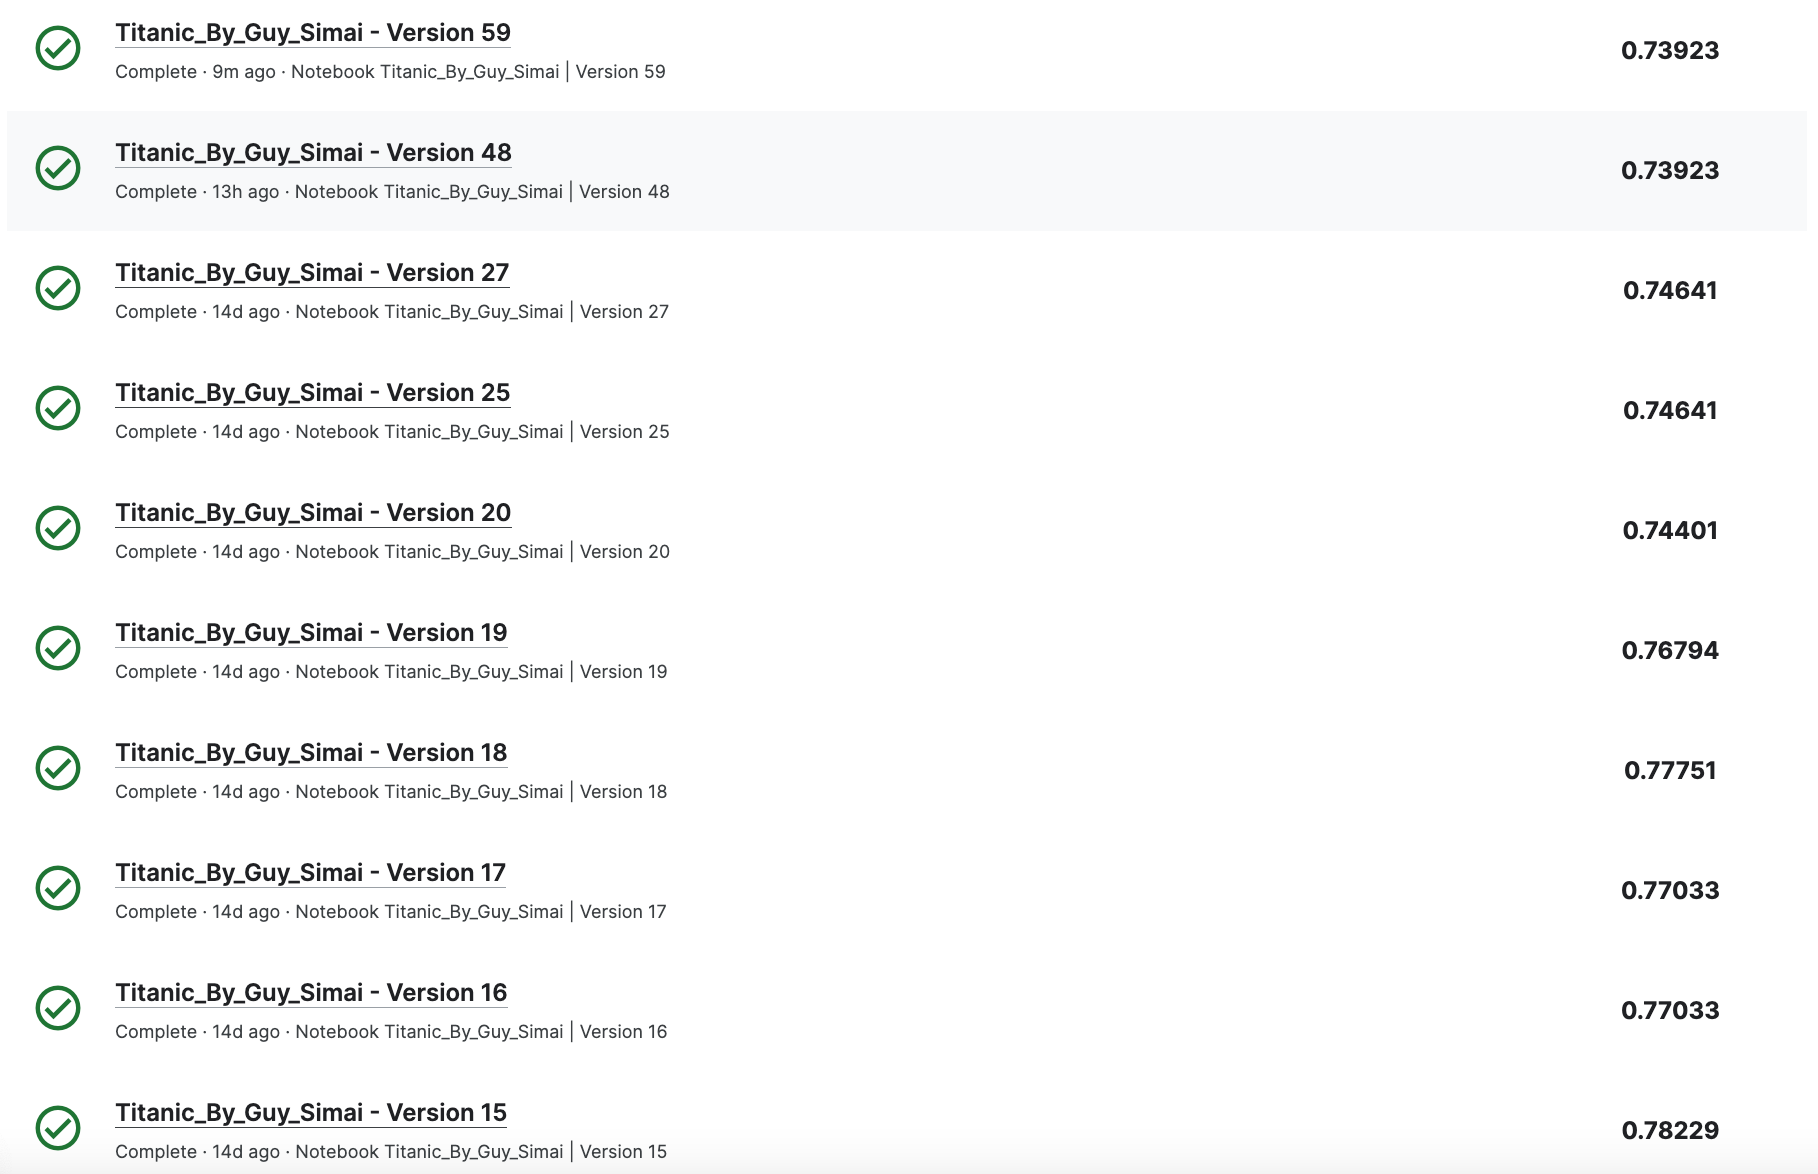

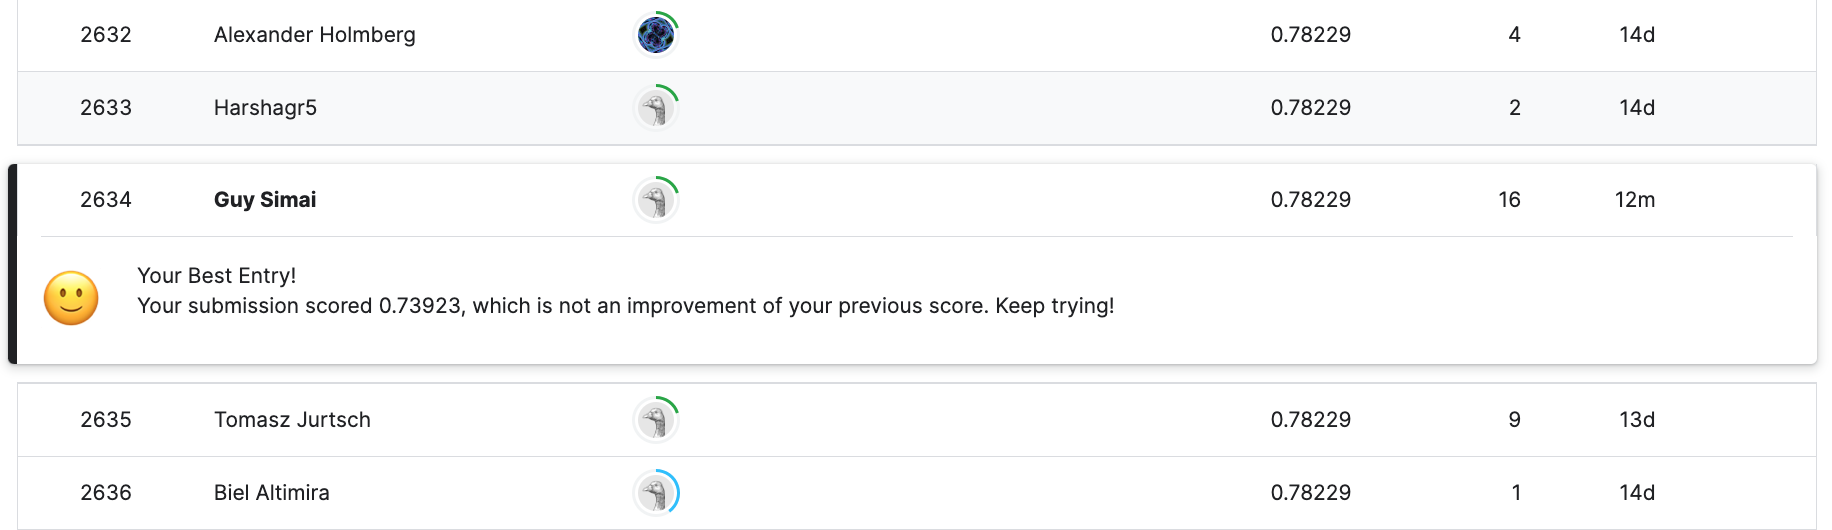

# Summary
Guy Simai

The first part of the project was very interesting.  
I learned how to manipulate the features by deleting unnecessary ones and changing some of them to numerical values.  
I conducted in-depth research on the data and created a feature for prediction accuracy.  After checking the GSD and MLP Classifier models, I chose the GSD because of the lower error. Then, I trained the models on the dataset.  
It seems that during training, the second model (with the additional feature) is more accurate and has a lower CE.  
So I submitted the second model that got the best score.

# References

* Seaborn - https://seaborn.pydata.org/tutorial.html  
* Sklrean - https://scikit-learn.org/stable
* kagglehttps - www.kaggle.com/code/nadintamer/titanic-survival-predictions-beginner
